In [1]:
from __future__ import division
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import plotly.offline as pyoff
import plotly as py
import plotly.graph_objs as go
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
pyoff.init_notebook_mode()
from plotly.offline import init_notebook_mode, iplot
py.offline.init_notebook_mode(connected=True) 
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.svm import SVC
from mlxtend.frequent_patterns import apriori, association_rules
import random

Using TensorFlow backend.


In [2]:
%time sales = pd.read_csv("data/Water_System_14-19.csv")

Wall time: 1.25 s


In [3]:
sales=sales.sort_values(by=['Date'])
sales_copy=sales

In [4]:
sales.head(10) 

Date          OrderNumber  OrderLineNumber  Quantity  SellPrice  \
29526  01/02/2014  order_number_111590              130         3   29.33326   
32568  01/02/2014  order_number_111590              300         1  111.99972   
32569  01/02/2014  order_number_111590              310         3  918.66437   
32570  01/02/2014  order_number_111590              310         2   35.99991   
32571  01/02/2014  order_number_111590              310         1  729.33151   
32572  01/02/2014  order_number_111590              310         2   45.33322   
32573  01/02/2014  order_number_111590              310         8   39.99990   
32574  01/02/2014  order_number_111590              310         8  206.66615   
32575  01/02/2014  order_number_111590              310         1   11.99997   
32576  01/02/2014  order_number_111590              310         1  171.99957   

             CCN         PartnerNumber  Material ItemCategoryGroup  \
29526  ccn_59201   partner_number_1153  mat_2998    item_cat_grp_6   
32568  ccn_17874  partner_number_40010  mat_5233    item_cat_grp_6   
32569  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1   
32570  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1   
32571  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1   
32572  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1   
32573  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1   
32574  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1   
32575  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1   
32576  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1   

      ItemCategory  ... Region SubRegion                    Industry  \
29526  item_cat_13  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   
32568  item_cat_13  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   
32569  item_cat_15  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   
32570  item_cat_15  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   
32571  item_cat_15  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   
32572  item_cat_15  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   
32573  item_cat_15  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   
32574  item_cat_15  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   
32575  item_cat_15  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   
32576  item_cat_15  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   

      IndustryGroup       Plant   PlantType     PlantPlatform  \
29526         WATER      Moosic  Unassigned  plant_platform_2   
32568         WATER  Chesapeake  Unassigned  plant_platform_1   
32569         WATER  Chesapeake  Unassigned  plant_platform_1   
32570         WATER  Chesapeake  Unassigned  plant_platform_1   
32571         WATER  Chesapeake  Unassigned  plant_platform_1   
32572         WATER  Chesapeake  Unassigned  plant_platform_1   
32573         WATER  Chesapeake  Unassigned  plant_platform_1   
32574         WATER  Chesapeake  Unassigned  plant_platform_1   
32575         WATER  Chesapeake  Unassigned  plant_platform_1   
32576         WATER  Chesapeake  Unassigned  plant_platform_1   

                Market MonthYear Column 32  
29526  Water Resources   01/2014       NaN  
32568  Water Resources   01/2014       NaN  
32569  Water Resources   01/2014       NaN  
32570  Water Resources   01/2014       NaN  
32571  Water Resources   01/2014       NaN  
32572  Water Resources   01/2014       NaN  
32573  Water Resources   01/2014       NaN  
32574  Water Resources   01/2014       NaN  
32575  Water Resources   01/2014       NaN  
32576  Water Resources   01/2014       NaN  

[10 rows x 32 columns]

In [5]:
print (sales.dtypes)

Date                    object
OrderNumber             object
OrderLineNumber          int64
Quantity                 int64
SellPrice              float64
CCN                     object
PartnerNumber           object
Material                object
ItemCategoryGroup       object
ItemCategory            object
ItemDescription         object
ProductCode             object
ProductDescription      object
NounCodeDescription     object
NounCode                object
ShipFrom                object
CustomerName            object
CustId                  object
City                    object
State                   object
PostalCode              object
Country                 object
Region                  object
SubRegion               object
Industry                object
IndustryGroup           object
Plant                   object
PlantType               object
PlantPlatform           object
Market                  object
MonthYear               object
Column 32              float64
dtype: o

In [6]:
#RFM calculation

#converting the type of Invoice Date Field from string to datetime.
sales['Date'] = pd.to_datetime(sales['Date'])

#creating YearMonth field for the ease of reporting and visualization
sales['InvoiceYearMonth'] = sales['Date'].map(lambda date: 100*date.year + date.month)

#calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
sales['Revenue'] = sales['SellPrice'] * sales['Quantity']

fs_revenue = sales.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
fs_revenue

InvoiceYearMonth       Revenue
0             201401  2.751596e+06
1             201402  2.201021e+06
2             201403  3.150713e+06
3             201404  4.530337e+06
4             201405  3.159471e+06
..               ...           ...
60            201901  5.951188e+06
61            201902  5.425985e+06
62            201903  5.232379e+06
63            201904  3.538122e+06
64            201905  9.586643e+05

[65 rows x 2 columns]

In [7]:
#X and Y axis inputs for Plotly graph. We use Scatter for line graphs
plot_data = [
    go.Scatter(
        x=fs_revenue['InvoiceYearMonth'],
        y=fs_revenue['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Potential outliers in 12/2015, 

In [8]:
sales.head(1)

Date          OrderNumber  OrderLineNumber  Quantity  SellPrice  \
29526 2014-01-02  order_number_111590              130         3   29.33326   

             CCN        PartnerNumber  Material ItemCategoryGroup  \
29526  ccn_59201  partner_number_1153  mat_2998    item_cat_grp_6   

      ItemCategory  ...                    Industry IndustryGroup   Plant  \
29526  item_cat_13  ...  WATER SYSTEMS EXTR & TRMNT         WATER  Moosic   

        PlantType     PlantPlatform           Market MonthYear Column 32  \
29526  Unassigned  plant_platform_2  Water Resources   01/2014       NaN   

      InvoiceYearMonth   Revenue  
29526           201401  87.99978  

[1 rows x 34 columns]

In [9]:
temp_data=sales.query("Date >'2015-12-01' and Date <'2016-01-01'" )
temp_data=temp_data.sort_values(by='Quantity', ascending=False)
temp_data

Date          OrderNumber  OrderLineNumber  Quantity  SellPrice  \
66155 2015-12-11  order_number_249449              100       168   70.66649   
66186 2015-12-11  order_number_249449              110       168   70.66649   
66434 2015-12-11  order_number_249449              190       168   70.66649   
66403 2015-12-11  order_number_249449              180       168   70.66649   
66620 2015-12-11  order_number_249449              240       168   70.66649   
...          ...                  ...              ...       ...        ...   
81230 2015-12-17  order_number_227759               30         1   39.99990   
81231 2015-12-17  order_number_227759               30         1  138.66632   
91261 2015-12-17  order_number_141222               40         1   57.33319   
91262 2015-12-17  order_number_141222               40         1  271.99932   
70085 2015-12-29  order_number_189500               50         1  465.33217   

             CCN         PartnerNumber  Material ItemCategoryGroup  \
66155  ccn_89839    partner_number_523  mat_5012    item_cat_grp_6   
66186  ccn_67202  partner_number_81889  mat_5012    item_cat_grp_6   
66434  ccn_94739  partner_number_13906  mat_3093    item_cat_grp_0   
66403  ccn_25413  partner_number_83389  mat_3093    item_cat_grp_0   
66620  ccn_73453  partner_number_97098  mat_5012    item_cat_grp_6   
...          ...                   ...       ...               ...   
81230  ccn_84802  partner_number_24982  mat_2265    item_cat_grp_5   
81231  ccn_84802  partner_number_24982  mat_2265    item_cat_grp_5   
91261  ccn_88721  partner_number_81170  mat_3461    item_cat_grp_1   
91262  ccn_88721  partner_number_81170  mat_3461    item_cat_grp_1   
70085  ccn_44267  partner_number_35096  mat_3249    item_cat_grp_0   

      ItemCategory  ...                    Industry IndustryGroup       Plant  \
66155  item_cat_13  ...  WATER SYSTEMS EXTR & TRMNT         WATER      Moosic   
66186  item_cat_13  ...  WATER SYSTEMS EXTR & TRMNT         WATER      Moosic   
66434   item_cat_1  ...  WATER SYSTEMS EXTR & TRMNT         WATER      Moosic   
66403   item_cat_1  ...  WATER SYSTEMS EXTR & TRMNT         WATER      Moosic   
66620  item_cat_13  ...  WATER SYSTEMS EXTR & TRMNT         WATER      Moosic   
...            ...  ...                         ...           ...         ...   
81230  item_cat_11  ...  WATER SYSTEMS EXTR & TRMNT         WATER   Taneytown   
81231  item_cat_11  ...  WATER SYSTEMS EXTR & TRMNT         WATER   Taneytown   
91261   item_cat_8  ...  WATER SYSTEMS EXTR & TRMNT         WATER      Moosic   
91262   item_cat_8  ...  WATER SYSTEMS EXTR & TRMNT         WATER      Moosic   
70085   item_cat_7  ...  WATER SYSTEMS EXTR & TRMNT         WATER  Chesapeake   

        PlantType     PlantPlatform           Market MonthYear Column 32  \
66155  Unassigned  plant_platform_2  Water Resources   12/2015       NaN   
66186  Unassigned  plant_platform_2  Water Resources   12/2015       NaN   
66434  Unassigned  plant_platform_2  Water Resources   12/2015       NaN   
66403  Unassigned  plant_platform_2  Water Resources   12/2015       NaN   
66620  Unassigned  plant_platform_2  Water Resources   12/2015       NaN   
...           ...               ...              ...       ...       ...   
81230  Unassigned  plant_platform_1  Water Resources   12/2015       NaN   
81231  Unassigned  plant_platform_1  Water Resources   12/2015       NaN   
91261  Unassigned  plant_platform_2  Water Resources   12/2015       NaN   
91262  Unassigned  plant_platform_2  Water Resources   12/2015       NaN   
70085  Unassigned  plant_platform_1  Water Resources   12/2015       NaN   

      InvoiceYearMonth      Revenue  
66155           201512  11871.97032  
66186           201512  11871.97032  
66434           201512  11871.97032  
66403           201512  11871.97032  
66620           201512  11871.97032  
...                ...          ...  
81230           201512     39.99990  
81231           201512    138.66

In [10]:
#Calculate monthly change in percantage (pct_change)

fs_revenue['MonthlyGrowth'] = fs_revenue['Revenue'].pct_change()*100
fs_revenue['MonthlyGrowth'].head(20)

0            NaN
1     -20.009284
2      43.147804
3      43.787645
4     -30.259692
5     -12.040932
6     -41.864264
7      30.313151
8      94.886968
9      30.937714
10    -20.509202
11    -40.742286
12     11.242155
13     -5.887605
14    118.713788
15    -23.478356
16    -14.627337
17    -11.536977
18    -20.854920
19     46.018271
Name: MonthlyGrowth, dtype: float64

In [11]:
#visualization - line graph
plot_data = [
    go.Scatter(
        x=fs_revenue.query("InvoiceYearMonth < 201912")['InvoiceYearMonth'],
        y=fs_revenue.query("InvoiceYearMonth < 201912")['MonthlyGrowth'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Growth Rate'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [12]:
# count customers ID's for each month
fs_monthly_active = sales.groupby('InvoiceYearMonth')['CustId'].nunique().reset_index()
fs_monthly_active.head(10)

InvoiceYearMonth  CustId
0            201401      20
1            201402      24
2            201403      20
3            201404      27
4            201405      20
5            201406      24
6            201407      20
7            201408      19
8            201409      23
9            201410      26

In [13]:
#ax = fs_monthly_active.plot.bar(x='InvoiceYearMonth', y='CustId', rot=0, figsize=(20, 6))

plot_data = [
    go.Bar(
        x=fs_monthly_active['InvoiceYearMonth'],
        y=fs_monthly_active['CustId'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Active Customers'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [14]:
# number of orders for each month
fs_monthly_active = sales.groupby('InvoiceYearMonth')['Quantity'].sum().reset_index()
fs_monthly_active.head(10)

InvoiceYearMonth  Quantity
0            201401      9620
1            201402      8255
2            201403      9606
3            201404      9095
4            201405      8875
5            201406      6284
6            201407      4285
7            201408      5450
8            201409     11934
9            201410      7485

In [15]:
#ax = fs_monthly_active.plot.bar(x='InvoiceYearMonth', y='Quantity', rot=0, figsize=(20, 6))

plot_data = [
    go.Bar(
        x=fs_monthly_active['InvoiceYearMonth'],
        y=fs_monthly_active['Quantity'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Number of Orders'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [16]:
# average revenue for each month 

fs_monthly_active = sales.groupby('InvoiceYearMonth')['Revenue'].mean().reset_index()
fs_monthly_active.head(10)

InvoiceYearMonth      Revenue
0            201401   605.411614
1            201402   483.847255
2            201403   701.717919
3            201404   797.594485
4            201405   688.487855
5            201406   857.464070
6            201407   654.360454
7            201408   839.792609
8            201409  1008.869537
9            201410  1509.544601

In [17]:
#ax = fs_monthly_active.plot.bar(x='InvoiceYearMonth', y='Revenue', rot=0, figsize=(20, 6))

#plot the bar chart
plot_data = [
    go.Bar(
        x=fs_monthly_active['InvoiceYearMonth'],
        y=fs_monthly_active['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Order Average'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [18]:
#create a dataframe contaning CustomerID and first purchase date

fs_min_purchase = sales.groupby('CustId').Date.min().reset_index()
fs_min_purchase.columns = ['CustId','MinPurchaseDate']
fs_min_purchase['MinPurchaseYearMonth'] = fs_min_purchase['MinPurchaseDate'].map(lambda date: 100*date.year + date.month)
fs_min_purchase

CustId MinPurchaseDate  MinPurchaseYearMonth
0    cust_id_1037      2015-05-26                201505
1    cust_id_1044      2014-01-28                201401
2    cust_id_1072      2018-11-29                201811
3    cust_id_1110      2015-04-17                201504
4    cust_id_1140      2015-02-09                201502
..            ...             ...                   ...
129   cust_id_925      2014-01-07                201401
130   cust_id_928      2014-04-17                201404
131   cust_id_946      2017-02-02                201702
132   cust_id_963      2016-02-19                201602
133   cust_id_996      2014-02-05                201402

[134 rows x 3 columns]

In [19]:
#merge first purchase date column to our main dataframe
sales = pd.merge(sales, fs_min_purchase, on='CustId')
sales.head(5)

Date          OrderNumber  OrderLineNumber  Quantity  SellPrice  \
0 2014-01-02  order_number_111590              130         3   29.33326   
1 2014-01-02  order_number_111590              300         1  111.99972   
2 2014-01-02  order_number_111590              310         3  918.66437   
3 2014-01-02  order_number_111590              310         2   35.99991   
4 2014-01-02  order_number_111590              310         1  729.33151   

         CCN         PartnerNumber  Material ItemCategoryGroup ItemCategory  \
0  ccn_59201   partner_number_1153  mat_2998    item_cat_grp_6  item_cat_13   
1  ccn_17874  partner_number_40010  mat_5233    item_cat_grp_6  item_cat_13   
2  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1  item_cat_15   
3  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1  item_cat_15   
4  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1  item_cat_15   

   ...       Plant   PlantType     PlantPlatform           Market MonthYear  \
0  ...      Moosic  Unassigned  plant_platform_2  Water Resources   01/2014   
1  ...  Chesapeake  Unassigned  plant_platform_1  Water Resources   01/2014   
2  ...  Chesapeake  Unassigned  plant_platform_1  Water Resources   01/2014   
3  ...  Chesapeake  Unassigned  plant_platform_1  Water Resources   01/2014   
4  ...  Chesapeake  Unassigned  plant_platform_1  Water Resources   01/2014   

  Column 32 InvoiceYearMonth     Revenue MinPurchaseDate MinPurchaseYearMonth  
0       NaN           201401    87.99978      2014-01-02               201401  
1       NaN           201401   111.99972      2014-01-02               201401  
2       NaN           201401  2755.99311      2014-01-02               201401  
3       NaN           201401    71.99982      2014-01-02               201401  
4       NaN           201401   729.33151      2014-01-02               201401  

[5 rows x 36 columns]

In [20]:
#create a column called User Type and assign New or Existing 

sales['UserType'] = 'New'
sales.loc[sales['InvoiceYearMonth']>sales['MinPurchaseYearMonth'],'UserType'] = 'Existing'
sales.head(5)

Date          OrderNumber  OrderLineNumber  Quantity  SellPrice  \
0 2014-01-02  order_number_111590              130         3   29.33326   
1 2014-01-02  order_number_111590              300         1  111.99972   
2 2014-01-02  order_number_111590              310         3  918.66437   
3 2014-01-02  order_number_111590              310         2   35.99991   
4 2014-01-02  order_number_111590              310         1  729.33151   

         CCN         PartnerNumber  Material ItemCategoryGroup ItemCategory  \
0  ccn_59201   partner_number_1153  mat_2998    item_cat_grp_6  item_cat_13   
1  ccn_17874  partner_number_40010  mat_5233    item_cat_grp_6  item_cat_13   
2  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1  item_cat_15   
3  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1  item_cat_15   
4  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1  item_cat_15   

   ...   PlantType     PlantPlatform           Market MonthYear Column 32  \
0  ...  Unassigned  plant_platform_2  Water Resources   01/2014       NaN   
1  ...  Unassigned  plant_platform_1  Water Resources   01/2014       NaN   
2  ...  Unassigned  plant_platform_1  Water Resources   01/2014       NaN   
3  ...  Unassigned  plant_platform_1  Water Resources   01/2014       NaN   
4  ...  Unassigned  plant_platform_1  Water Resources   01/2014       NaN   

  InvoiceYearMonth     Revenue MinPurchaseDate MinPurchaseYearMonth UserType  
0           201401    87.99978      2014-01-02               201401      New  
1           201401   111.99972      2014-01-02               201401      New  
2           201401  2755.99311      2014-01-02               201401      New  
3           201401    71.99982      2014-01-02               201401      New  
4           201401   729.33151      2014-01-02               201401      New  

[5 rows x 37 columns]

In [21]:
#calculate the Revenue per month for each user type
fs_user_type_revenue = sales.groupby(['InvoiceYearMonth','UserType'])['Revenue'].sum().reset_index()
fs_user_type_revenue.head(5)

InvoiceYearMonth  UserType       Revenue
0            201401       New  2.751596e+06
1            201402  Existing  1.976800e+06
2            201402       New  2.242208e+05
3            201403  Existing  2.946885e+06
4            201403       New  2.038288e+05

In [22]:
#filtering the dates and plot the result, just to show the data
fs_user_type_revenue1 = fs_user_type_revenue.query("InvoiceYearMonth > 201512")
fs_user_type_revenue1

InvoiceYearMonth  UserType       Revenue
44             201601  Existing  5.683203e+06
45             201601       New  1.627729e+04
46             201602  Existing  6.036873e+06
47             201602       New  4.628388e+04
48             201603  Existing  9.923094e+06
..                ...       ...           ...
106            201902  Existing  5.425985e+06
107            201903  Existing  5.232379e+06
108            201904  Existing  3.421183e+06
109            201904       New  1.169384e+05
110            201905  Existing  9.586643e+05

[67 rows x 3 columns]

In [23]:
plot_data = [
    go.Scatter(
        x=fs_user_type_revenue.query("UserType == 'Existing'")['InvoiceYearMonth'],
        y=fs_user_type_revenue.query("UserType == 'Existing'")['Revenue'],
        name = 'Existing'
    ),
    go.Scatter(
        x=fs_user_type_revenue.query("UserType == 'New'")['InvoiceYearMonth'],
        y=fs_user_type_revenue.query("UserType == 'New'")['Revenue'],
        name = 'New'
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New vs Existing'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [24]:
#create a dataframe that shows new user ratio - we also need to drop NA values (first month new user ratio is 0)
fs_user_ratio = sales.query("UserType == 'New'").groupby(['InvoiceYearMonth'])['CustId'].nunique()/sales.query("UserType == 'Existing'").groupby(['InvoiceYearMonth'])['CustId'].nunique() 
fs_user_ratio = fs_user_ratio.reset_index()
fs_user_ratio = fs_user_ratio.dropna()
#<1 - existing more
#print the dafaframe
fs_user_ratio

InvoiceYearMonth    CustId
1             201402  0.600000
2             201403  0.538462
3             201404  0.588235
4             201405  0.052632
5             201406  0.200000
6             201407  0.250000
7             201408  0.117647
8             201409  0.095238
9             201410  0.238095
10            201411  0.181818
11            201412  0.136364
12            201501  0.076923
13            201502  0.086957
14            201503  0.095238
15            201504  0.173913
16            201505  0.045455
17            201506  0.363636
19            201508  0.074074
21            201510  0.095238
22            201511  0.071429
24            201601  0.047619
25            201602  0.117647
26            201603  0.130435
27            201604  0.100000
28            201605  0.047619
29            201606  0.076923
31            201608  0.150000
32            201609  0.111111
35            201612  0.050000
36            201701  0.133333
37            201702  0.100000
39            201704  0.050000
40            201705  0.052632
41            201706  0.062500
42            201707  0.058824
44            201709  0.058824
48            201801  0.133333
49            201802  0.055556
52            201805  0.176471
53            201806  0.052632
54            201807  0.062500
55            201808  0.041667
56            201809  0.125000
58            201811  0.058824
60            201901  0.047619
63            201904  0.055556

In [25]:
#plot the result

plot_data = [
    go.Bar(
        x=fs_user_ratio.query("InvoiceYearMonth>201501 and InvoiceYearMonth<201912")['InvoiceYearMonth'],
        y=fs_user_ratio.query("InvoiceYearMonth>201501 and InvoiceYearMonth<201912")['CustId'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New Customer Ratio'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [26]:
#identify which users are active by looking at their revenue per month
fs_user_purchase = sales.groupby(['CustId','InvoiceYearMonth'])['Revenue'].sum().reset_index()
fs_user_purchase

CustId  InvoiceYearMonth      Revenue
0     cust_id_1037            201505    807.99798
1     cust_id_1044            201401   5269.32016
2     cust_id_1044            201604  31050.58904
3     cust_id_1044            201606  55279.86180
4     cust_id_1044            201705    191.99952
...            ...               ...          ...
1335   cust_id_946            201708   5599.98600
1336   cust_id_946            201709    229.33276
1337   cust_id_946            201802    399.99900
1338   cust_id_963            201602    458.66552
1339   cust_id_996            201402    809.33131

[1340 rows x 3 columns]

In [27]:
#plot the bar chart
plot_data = [
    go.Bar(
        x=fs_monthly_active['InvoiceYearMonth'],
        y=fs_monthly_active['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Order Average'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [28]:
#Retention calculatio :
#Monthly Retention Rate = Retained Customers From Prev. Month/Active Customers Total

In [29]:
#create retention matrix with crosstab
fs_retention = pd.crosstab(fs_user_purchase['CustId'], fs_user_purchase['InvoiceYearMonth']).reset_index()

fs_retention.head(5)

InvoiceYearMonth        CustId  201401  201402  201403  201404  201405  \
0                 cust_id_1037       0       0       0       0       0   
1                 cust_id_1044       1       0       0       0       0   
2                 cust_id_1072       0       0       0       0       0   
3                 cust_id_1110       0       0       0       0       0   
4                 cust_id_1140       0       0       0       0       0   

InvoiceYearMonth  201406  201407  201408  201409  ...  201808  201809  201810  \
0                      0       0       0       0  ...       0       0       0   
1                      0       0       0       0  ...       0       0       0   
2                      0       0       0       0  ...       0       0       0   
3                      0       0       0       0  ...       0       0       0   
4                      0       0       0       0  ...       0       0       0   

InvoiceYearMonth  201811  201812  201901  201902  201903  201904  201905  
0                      0       0       0       0       0       0       0  
1                      0       0       0       0       0       0       0  
2                      1       0       0       0       0       0       0  
3                      0       0       0       0       0       0       0  
4                      0       0       0       0       0       0       0  

[5 rows x 66 columns]

In [30]:
#create an array of dictionary which keeps Retained & Total User count for each month
#customer bought in 2 consequencs months

months = fs_retention.columns[2:]
retention_array = []

for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = int(selected_month)
    retention_data['TotalUserCount'] = fs_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = fs_retention[(fs_retention[selected_month]>0) & (fs_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
fs_retention = pd.DataFrame(retention_array)
fs_retention['RetentionRate'] = fs_retention['RetainedUserCount']/fs_retention['TotalUserCount']
fs_retention

InvoiceYearMonth  TotalUserCount  RetainedUserCount  RetentionRate
0             201403              20                 13       0.650000
1             201404              27                 11       0.407407
2             201405              20                 16       0.800000
3             201406              24                 15       0.625000
4             201407              20                 13       0.650000
..               ...             ...                ...            ...
58            201901              22                 15       0.681818
59            201902              17                 13       0.764706
60            201903              21                 14       0.666667
61            201904              19                 13       0.684211
62            201905               7                  6       0.857143

[63 rows x 4 columns]

In [31]:
#plot the retention rate graph
plot_data = [
    go.Scatter(
        x=fs_retention.query("InvoiceYearMonth<201912")['InvoiceYearMonth'],
        y=fs_retention.query("InvoiceYearMonth<201912")['RetentionRate'],
        name="organic"
    )
    
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Retention Rate'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [32]:
#create our retention table again with crosstab() - we need to change the column names for using them in .query() function
#convert retention 0,1 to rate
#getting 1 customer ID with purchase month

fs_retention = pd.crosstab(fs_user_purchase['CustId'], fs_user_purchase['InvoiceYearMonth']).reset_index()
#new column names
new_column_names = [ 'm_' + str(column) for column in fs_retention.columns]
fs_retention.columns = new_column_names

#create the array of Retained users for each cohort monthly
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count =  retention_data['TotalUserCount'] = fs_retention['m_' + str(selected_month)].sum()
    retention_data[selected_month] = 1 
    
    query = "{} > 0".format('m_' + str(selected_month))
    

    for next_month in next_months:
        query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(fs_retention.query(query)['m_' + str(next_month)].sum()/total_user_count,2)
        
    retention_array.append(retention_data)
    
fs_retention = pd.DataFrame(retention_array)
fs_retention.index = months

#showing new cohort based retention table
fs_retention

TotalUserCount  201402  201403  201404  201405  201406  \
InvoiceYearMonth                                                           
201402                        24     1.0    0.54    0.46    0.38    0.38   
201403                        20     NaN    1.00    0.55    0.45    0.45   
201404                        27     NaN     NaN    1.00    0.59    0.52   
201405                        20     NaN     NaN     NaN    1.00    0.75   
201406                        24     NaN     NaN     NaN     NaN    1.00   
...                          ...     ...     ...     ...     ...     ...   
201901                        22     NaN     NaN     NaN     NaN     NaN   
201902                        17     NaN     NaN     NaN     NaN     NaN   
201903                        21     NaN     NaN     NaN     NaN     NaN   
201904                        19     NaN     NaN     NaN     NaN     NaN   
201905                         7     NaN     NaN     NaN     NaN     NaN   

                  201407  201408  201409  201410  ...  201808  201809  201810  \
InvoiceYearMonth                                  ...                           
201402              0.33    0.33    0.33    0.25  ...    0.08    0.08    0.08   
201403              0.40    0.40    0.40    0.30  ...    0.10    0.10    0.10   
201404              0.44    0.37    0.33    0.26  ...    0.07    0.07    0.07   
201405              0.60    0.50    0.45    0.35  ...    0.10    0.10    0.10   
201406              0.54    0.46    0.38    0.29  ...    0.08    0.08    0.08   
...                  ...     ...     ...     ...  ...     ...     ...     ...   
201901               NaN     NaN     NaN     NaN  ...     NaN     NaN     NaN   
201902               NaN     NaN     NaN     NaN  ...     NaN     NaN     NaN   
201903               NaN     NaN     NaN     NaN  ...     NaN     NaN     NaN   
201904               NaN     NaN     NaN     NaN  ...     NaN     NaN     NaN   
201905               NaN     NaN     NaN     NaN  ...     NaN     NaN     NaN   

                  201811  201812  201901  201902  201903  201904  201905  
InvoiceYearMonth                                                          
201402              0.08    0.08    0.08    0.08    0.08    0.08    0.08  
201403              0.10    0.10    0.10    0.10    0.10    0.10    0.10  
201404              0.07    0.07    0.07    0.07    0.07    0.07    0.07  
201405              0.10    0.10    0.10    0.10    0.10    0.10    0.10  
201406              0.08    0.08    0.08    0.08    0.08    0.08    0.08  
...                  ...     ...     ...     ...     ...     ...     ...  
201901               NaN     NaN    1.00    0.59    0.59    0.55    0.23  
201902               NaN     NaN     NaN    1.00    0.82    0.71    0.29  
201903               NaN     NaN     NaN     NaN    1.00    0.62    0.24  
201904               NaN     NaN     NaN     NaN     NaN    1.00    0.32  
201905               NaN     NaN     NaN     NaN     NaN     NaN    1.00  

[64 rows x 65 columns]

In [33]:
#dropping customer, think outliers
sales.drop(sales.loc[sales['CustId']=='cust_id_576'].index, inplace=True)
sales.drop(sales.loc[sales['CustId']=='cust_id_1653'].index, inplace=True)
sales.shape

(115660, 37)

RFM (recency, frequency, monetary) analysis is a marketing technique used to determine quantitatively which customers are the best ones by examining how recently a customer has purchased (recency), how often they purchase (frequency), and how much the customer spends (monetary).

In [34]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
sales_cust = pd.DataFrame(sales['CustId'].unique())
sales_cust.columns = ['CustId']
sales_cust

CustId
0    cust_id_2558
1    cust_id_1549
2    cust_id_3970
3     cust_id_190
4    cust_id_4253
..            ...
127  cust_id_1198
128  cust_id_3726
129  cust_id_1072
130  cust_id_2452
131  cust_id_2203

[132 rows x 1 columns]

In [35]:
#get the max purchase date for each customer and create a dataframe with it
fs_max_purchase = sales.groupby('CustId').Date.max().reset_index()
fs_max_purchase.columns = ['CustId','MaxPurchaseDate']
fs_max_purchase

CustId MaxPurchaseDate
0    cust_id_1037      2015-05-26
1    cust_id_1044      2018-02-09
2    cust_id_1072      2018-11-29
3    cust_id_1110      2015-06-08
4    cust_id_1140      2015-02-09
..            ...             ...
127   cust_id_925      2016-09-22
128   cust_id_928      2014-04-17
129   cust_id_946      2018-02-01
130   cust_id_963      2016-02-19
131   cust_id_996      2014-02-05

[132 rows x 2 columns]

In [36]:
fs_max_purchase['MaxPurchaseDate'] = pd.to_datetime(fs_max_purchase['MaxPurchaseDate'])
print (fs_max_purchase.dtypes)
fs_max_purchase

CustId                     object
MaxPurchaseDate    datetime64[ns]
dtype: object


CustId MaxPurchaseDate
0    cust_id_1037      2015-05-26
1    cust_id_1044      2018-02-09
2    cust_id_1072      2018-11-29
3    cust_id_1110      2015-06-08
4    cust_id_1140      2015-02-09
..            ...             ...
127   cust_id_925      2016-09-22
128   cust_id_928      2014-04-17
129   cust_id_946      2018-02-01
130   cust_id_963      2016-02-19
131   cust_id_996      2014-02-05

[132 rows x 2 columns]

In [37]:
# mask = (fs_max_purchase['MaxPurchaseDate'] > "2018-01-01")
# fs_max_purchase.loc[mask]

In [38]:
#we take our observation point as the max invoice date in our dataset
#calculate difference between max purchace and last purcahse
fs_max_purchase['Recency'] = (fs_max_purchase['MaxPurchaseDate'].max() - fs_max_purchase['MaxPurchaseDate']).dt.days
fs_max_purchase

CustId MaxPurchaseDate  Recency
0    cust_id_1037      2015-05-26     1442
1    cust_id_1044      2018-02-09      452
2    cust_id_1072      2018-11-29      159
3    cust_id_1110      2015-06-08     1429
4    cust_id_1140      2015-02-09     1548
..            ...             ...      ...
127   cust_id_925      2016-09-22      957
128   cust_id_928      2014-04-17     1846
129   cust_id_946      2018-02-01      460
130   cust_id_963      2016-02-19     1173
131   cust_id_996      2014-02-05     1917

[132 rows x 3 columns]

In [39]:
#merge this dataframe to our new user dataframe
fs_cust = pd.merge(sales_cust, fs_max_purchase[['CustId','Recency']], on='CustId')
fs_cust.head(5)

CustId  Recency
0  cust_id_2558       32
1  cust_id_1549       13
2  cust_id_3970        1
3   cust_id_190       28
4  cust_id_4253       54

In [40]:
#plot a recency histogram

plot_data = [
    go.Histogram(
        x=fs_cust['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [41]:
fs_cust.Recency.describe()

count     132.000000
mean      858.727273
std       631.499175
min         0.000000
25%       251.750000
50%       890.000000
75%      1430.000000
max      1917.000000
Name: Recency, dtype: float64

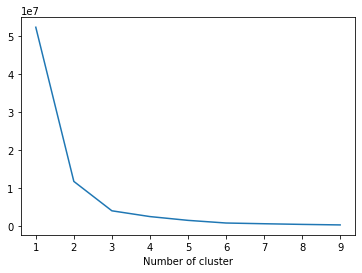

In [42]:
from sklearn.cluster import KMeans
# inertia - Sum of squared distances of samples to their closest cluster center.
sse={}
fs_recency = fs_cust[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(fs_recency)
    fs_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [43]:
n_clusters=4

In [44]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Recency']])
fs_cust['RecencyCluster'] = kmeans.predict(fs_cust[['Recency']])
fs_cust

CustId  Recency  RecencyCluster
0    cust_id_2558       32               3
1    cust_id_1549       13               3
2    cust_id_3970        1               3
3     cust_id_190       28               3
4    cust_id_4253       54               3
..            ...      ...             ...
127  cust_id_1198     1632               0
128  cust_id_3726     1260               2
129  cust_id_1072      159               3
130  cust_id_2452      880               2
131  cust_id_2203     1603               0

[132 rows x 3 columns]

In [45]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

fs_cust = order_cluster('RecencyCluster', 'Recency',fs_cust,False)
fs_cust

CustId  Recency  RecencyCluster
0    cust_id_2558       32               3
1    cust_id_1549       13               3
2    cust_id_3970        1               3
3     cust_id_190       28               3
4    cust_id_4253       54               3
..            ...      ...             ...
127  cust_id_1351     1651               0
128  cust_id_3938     1650               0
129   cust_id_413     1649               0
130  cust_id_1198     1632               0
131  cust_id_2203     1603               0

[132 rows x 3 columns]

In [46]:
#fs_cust.groupby('RecencyCluster').describe().reset_index()
fs_cust.groupby('RecencyCluster')['Recency'].describe()

count         mean         std     min      25%     50%  \
RecencyCluster                                                            
0                41.0  1621.317073  169.860154  1362.0  1455.00  1623.0   
1                30.0  1030.500000  135.401256   810.0   941.00  1012.0   
2                24.0   548.333333  156.541331   322.0   438.25   510.0   
3                37.0    75.756757   86.435720     0.0    14.00    42.0   

                    75%     max  
RecencyCluster                   
0               1783.00  1917.0  
1               1142.25  1301.0  
2                689.50   770.0  
3                103.00   298.0

In [47]:
# Frequency clustering

#get order counts for each user and create a dataframe with it
fs_frequency = sales.groupby('CustId').Date.count().reset_index()
fs_frequency.columns = ['CustId','Frequency']

#add this data to our main dataframe
fs_cust = pd.merge(fs_cust, fs_frequency, on='CustId')
fs_cust

CustId  Recency  RecencyCluster  Frequency
0    cust_id_2558       32               3       1977
1    cust_id_1549       13               3      12047
2    cust_id_3970        1               3      16379
3     cust_id_190       28               3       2323
4    cust_id_4253       54               3        528
..            ...      ...             ...        ...
127  cust_id_1351     1651               0          4
128  cust_id_3938     1650               0         16
129   cust_id_413     1649               0          9
130  cust_id_1198     1632               0          4
131  cust_id_2203     1603               0         49

[132 rows x 4 columns]

In [48]:
#k-means
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Frequency']])
fs_cust['FrequencyCluster'] = kmeans.predict(fs_cust[['Frequency']])

#order the frequency cluster
fs_cust = order_cluster('FrequencyCluster', 'Frequency',fs_cust,True)

#see details of each cluster
fs_cust.groupby('FrequencyCluster')['Frequency'].describe()

count          mean          std      min       25%  \
FrequencyCluster                                                        
0                 111.0    121.009009   214.973550      1.0      4.00   
1                  12.0   2115.250000   765.777338   1274.0   1421.25   
2                   6.0   6052.833333  1106.596117   4718.0   5279.00   
3                   3.0  13509.333333  2485.356380  12047.0  12074.50   

                      50%      75%      max  
FrequencyCluster                             
0                    20.0    125.5   1026.0  
1                  2021.5   2947.0   3283.0  
2                  6062.5   6517.5   7787.0  
3                 12102.0  14240.5  16379.0

In [49]:
#plot the histogram
plot_data = [
    go.Histogram(
        x=fs_cust.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [50]:
# Revenue Clustering

#calculate revenue for each customer
fs_revenue = sales.groupby('CustId').Revenue.sum().reset_index()

#merge it with our main dataframe
fs_cust = pd.merge(fs_cust, fs_revenue, on='CustId')
fs_cust

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0    cust_id_2558       32               3       1977                 1   
1     cust_id_190       28               3       2323                 1   
2    cust_id_3856       13               3       1285                 1   
3    cust_id_3106       11               3       1274                 1   
4    cust_id_3857       57               3       2971                 1   
..            ...      ...             ...        ...               ...   
127  cust_id_2700        0               3       5723                 2   
128  cust_id_4196        1               3       7787                 2   
129  cust_id_3902        5               3       4718                 2   
130  cust_id_4020       27               3       6556                 2   
131   cust_id_674      540               2       6402                 2   

          Revenue  
0    1.224682e+06  
1    2.260908e+06  
2    6.237918e+05  
3    1.069855e+06  
4    6.820816e+06  
..            ...  
127  5.667996e+06  
128  6.036020e+06  
129  6.159354e+06  
130  9.305863e+06  
131  4.039034e+06  

[132 rows x 6 columns]

In [51]:
#apply clustering
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Revenue']])
fs_cust['RevenueCluster'] = kmeans.predict(fs_cust[['Revenue']])


#order the cluster numbers
fs_cust = order_cluster('RevenueCluster', 'Revenue',fs_cust,True)
fs_cust
#show details of the dataframe
fs_cust.groupby('RevenueCluster')['Revenue'].describe()

count          mean           std           min           25%  \
RevenueCluster                                                                  
0               118.0  2.375401e+05  4.672495e+05  5.333320e+01  4.824988e+03   
1                 8.0  5.147542e+06  1.205247e+06  3.381981e+06  4.179149e+06   
2                 4.0  1.017428e+07  1.732304e+06  8.411920e+06  9.082378e+06   
3                 2.0  1.798534e+07  3.559923e+06  1.546809e+07  1.672671e+07   

                         50%           75%           max  
RevenueCluster                                            
0               2.929526e+04  1.760842e+05  2.492823e+06  
1               5.258640e+06  6.066853e+06  6.820816e+06  
2               9.939232e+06  1.103114e+07  1.240675e+07  
3               1.798534e+07  1.924396e+07  2.050258e+07

In [52]:
fs_cust

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0    cust_id_2558       32               3       1977                 1   
1     cust_id_190       28               3       2323                 1   
2    cust_id_3856       13               3       1285                 1   
3    cust_id_3106       11               3       1274                 1   
4    cust_id_3001       56               3       1332                 1   
..            ...      ...             ...        ...               ...   
127  cust_id_1549       13               3      12047                 3   
128  cust_id_2721     1202               1       1001                 0   
129  cust_id_4020       27               3       6556                 2   
130  cust_id_3970        1               3      16379                 3   
131  cust_id_1626        0               3      12102                 3   

          Revenue  RevenueCluster  
0    1.224682e+06               0  
1    2.260908e+06               0  
2    6.237918e+05               0  
3    1.069855e+06               0  
4    1.354433e+06               0  
..            ...             ...  
127  1.057260e+07               2  
128  8.411920e+06               2  
129  9.305863e+06               2  
130  1.546809e+07               3  
131  2.050258e+07               3  

[132 rows x 7 columns]

In [53]:
#plot the histogram
plot_data = [
    go.Histogram(
        x=fs_cust.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [54]:
#calculate overall score and use mean() to see details

fs_cust['OverallScore'] = fs_cust['RecencyCluster'] + fs_cust['FrequencyCluster'] + fs_cust['RevenueCluster']
fs_cust.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()


Recency     Frequency       Revenue
OverallScore                                         
0             1621.317073     37.146341  4.301921e+04
1             1027.000000    115.357143  1.361761e+05
2              570.217391    157.826087  1.912781e+05
3              179.285714    453.857143  8.859647e+05
4               66.500000   1607.000000  1.310045e+06
5              166.000000   3594.500000  4.772779e+06
6               27.600000   5328.400000  6.899194e+06
7               27.000000   6556.000000  9.305863e+06
8               13.000000  12047.000000  1.057260e+07
9                0.500000  14240.500000  1.798534e+07

In [55]:
fs_cust['Segment'] = 'Low-Value'
fs_cust.loc[fs_cust['OverallScore']>3,'Segment'] = 'Mid-Value' 
fs_cust.loc[fs_cust['OverallScore']>5,'Segment'] = 'High-Value' 

In [56]:
fs_cust

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0    cust_id_2558       32               3       1977                 1   
1     cust_id_190       28               3       2323                 1   
2    cust_id_3856       13               3       1285                 1   
3    cust_id_3106       11               3       1274                 1   
4    cust_id_3001       56               3       1332                 1   
..            ...      ...             ...        ...               ...   
127  cust_id_1549       13               3      12047                 3   
128  cust_id_2721     1202               1       1001                 0   
129  cust_id_4020       27               3       6556                 2   
130  cust_id_3970        1               3      16379                 3   
131  cust_id_1626        0               3      12102                 3   

          Revenue  RevenueCluster  OverallScore     Segment  
0    1.224682e+06               0             4   Mid-Value  
1    2.260908e+06               0             4   Mid-Value  
2    6.237918e+05               0             4   Mid-Value  
3    1.069855e+06               0             4   Mid-Value  
4    1.354433e+06               0             4   Mid-Value  
..            ...             ...           ...         ...  
127  1.057260e+07               2             8  High-Value  
128  8.411920e+06               2             3   Low-Value  
129  9.305863e+06               2             7  High-Value  
130  1.546809e+07               3             9  High-Value  
131  2.050258e+07               3             9  High-Value  

[132 rows x 9 columns]

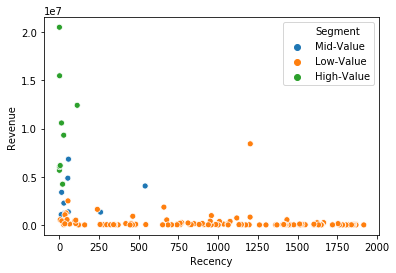

In [57]:
sns.scatterplot(x="Recency", y="Revenue", data=fs_cust, hue="Segment")

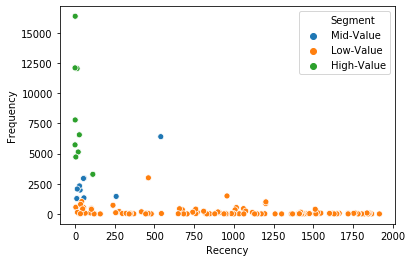

In [58]:
sns.scatterplot(x="Recency", y="Frequency", data=fs_cust, hue="Segment")

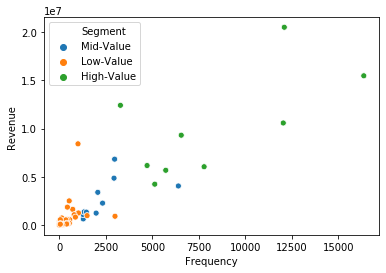

In [59]:
sns.scatterplot(x="Frequency", y="Revenue", data=fs_cust, hue="Segment")

In [60]:
#Revenue vs Frequency
fs_graph = fs_cust.query("Revenue < 50000 and Frequency < 2000")
fs_graph = fs_cust

plot_data = [
    go.Scatter(
        x=fs_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=fs_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=fs_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=fs_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=fs_graph.query("Segment == 'High-Value'")['Frequency'],
        y=fs_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#Revenue Recency

#fs_graph = fs_cust.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=fs_graph.query("Segment == 'Low-Value'")['Recency'],
        y=fs_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=fs_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=fs_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=fs_graph.query("Segment == 'High-Value'")['Recency'],
        y=fs_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# Revenue vs Frequency
#fs_graph = fs_cust.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=fs_graph.query("Segment == 'Low-Value'")['Recency'],
        y=fs_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=fs_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=fs_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=fs_graph.query("Segment == 'High-Value'")['Recency'],
        y=fs_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [61]:
# High Value: Improve Retention
# Mid Value: Improve Retention + Increase Frequency
# Low Value: Increase Frequency

In marketing, customer lifetime value (CLV or often CLTV), lifetime customer value (LCV), or life-time value (LTV) is a prediction of the net profit attributed to the entire future relationship with a customer.


In [62]:
#create 1year and rest data dataframes
#fs_1year = sales[(sales.Date < date(2014,6,1)) & (sales.Date >= date(2014,3,1))].reset_index(drop=True)
fs_calc = sales[(sales.Date >= date(2014,1,1)) & (sales.Date < date(2017,1,1))].reset_index(drop=True)
fs_next = sales[(sales.Date >= date(2017,1,1)) & (sales.Date < date(2019,12,31))].reset_index(drop=True)

In [63]:
#create fs for assigning clustering
fs_cust = pd.DataFrame(fs_calc['CustId'].unique())
fs_cust.columns = ['CustId']

In [64]:
#calculate recency score
fs_max_purchase = fs_calc.groupby('CustId').Date.max().reset_index()
fs_max_purchase.columns = ['CustId','MaxPurchaseDate']
fs_max_purchase['Recency'] = (fs_max_purchase['MaxPurchaseDate'].max() - fs_max_purchase['MaxPurchaseDate']).dt.days
fs_cust = pd.merge(fs_cust, fs_max_purchase[['CustId','Recency']], on='CustId')
fs_cust

CustId  Recency
0    cust_id_2558       37
1    cust_id_1549        3
2    cust_id_3970       11
3     cust_id_190        0
4    cust_id_4253      207
..            ...      ...
104   cust_id_413      791
105  cust_id_1198      774
106  cust_id_3726      402
107  cust_id_2452       22
108  cust_id_2203      745

[109 rows x 2 columns]

In [65]:
n_clusters=4
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Recency']])
fs_cust['RecencyCluster'] = kmeans.predict(fs_cust[['Recency']])

fs_cust = order_cluster('RecencyCluster', 'Recency',fs_cust,False)
fs_cust['RecencyCluster'].value_counts()

3    36
0    25
2    24
1    24
Name: RecencyCluster, dtype: int64

In [66]:
#calcuate frequency score
fs_frequency = fs_calc.groupby('CustId').Date.count().reset_index()
fs_frequency.columns = ['CustId','Frequency']
fs_cust = pd.merge(fs_cust, fs_frequency, on='CustId')
fs_cust

CustId  Recency  RecencyCluster  Frequency
0    cust_id_2558       37               3       1239
1    cust_id_1549        3               3       7052
2    cust_id_3970       11               3       7568
3     cust_id_190        0               3       1251
4    cust_id_3856      122               3        636
..            ...      ...             ...        ...
104  cust_id_1351      793               0          4
105  cust_id_3938      792               0         16
106   cust_id_413      791               0          9
107  cust_id_1198      774               0          4
108  cust_id_2203      745               0         49

[109 rows x 4 columns]

In [67]:
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Frequency']])
fs_cust['FrequencyCluster'] = kmeans.predict(fs_cust[['Frequency']])

fs_cust = order_cluster('FrequencyCluster', 'Frequency',fs_cust,True)
fs_cust['FrequencyCluster'].value_counts()
fs_cust

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster
0    cust_id_2558       37               3       1239                 1
1     cust_id_190        0               3       1251                 1
2    cust_id_3856      122               3        636                 1
3    cust_id_3106       11               3       1091                 1
4     cust_id_925       99               3       1490                 1
..            ...      ...             ...        ...               ...
104  cust_id_1351      793               0          4                 0
105  cust_id_3938      792               0         16                 0
106   cust_id_413      791               0          9                 0
107  cust_id_1198      774               0          4                 0
108  cust_id_2203      745               0         49                 0

[109 rows x 5 columns]

In [68]:
fs_cust['FrequencyCluster'].value_counts()

0    85
1    12
2     7
3     5
Name: FrequencyCluster, dtype: int64

In [69]:
#calcuate revenue score
fs_calc['Revenue'] = fs_calc['SellPrice'] * fs_calc['Quantity']
fs_revenue = fs_calc.groupby('CustId').Revenue.sum().reset_index()
fs_cust = pd.merge(fs_cust, fs_revenue, on='CustId')
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Revenue']])
fs_cust['RevenueCluster'] = kmeans.predict(fs_cust[['Revenue']])
fs_cust = order_cluster('RevenueCluster', 'Revenue',fs_cust,True)
fs_cust

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0    cust_id_2558       37               3       1239                 1   
1    cust_id_3856      122               3        636                 1   
2    cust_id_3106       11               3       1091                 1   
3     cust_id_925       99               3       1490                 1   
4    cust_id_3001       17               3        778                 1   
..            ...      ...             ...        ...               ...   
104  cust_id_1626        2               3       5634                 3   
105   cust_id_674       11               3       6085                 3   
106  cust_id_4020        1               3       3187                 2   
107  cust_id_2721      344               2       1001                 1   
108  cust_id_1556       24               3       2147                 2   

          Revenue  RevenueCluster  
0    8.879391e+05               0  
1    2.851953e+05               0  
2    7.409168e+05               0  
3    9.648429e+05               0  
4    7.796661e+05               0  
..            ...             ...  
104  5.800524e+06               2  
105  3.876590e+06               2  
106  4.275215e+06               2  
107  8.411920e+06               3  
108  1.062248e+07               3  

[109 rows x 7 columns]

In [70]:
fs_cust['RevenueCluster'].value_counts()

0    91
1    10
2     6
3     2
Name: RevenueCluster, dtype: int64

In [71]:
#overall scoring
fs_cust['OverallScore'] = fs_cust['RecencyCluster'] + fs_cust['FrequencyCluster'] + fs_cust['RevenueCluster']
fs_cust['Segment'] = 'Low-Value'
fs_cust.loc[fs_cust['OverallScore']>3,'Segment'] = 'Mid-Value' 
fs_cust.loc[fs_cust['OverallScore']>5,'Segment'] = 'High-Value' 
fs_cust

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0    cust_id_2558       37               3       1239                 1   
1    cust_id_3856      122               3        636                 1   
2    cust_id_3106       11               3       1091                 1   
3     cust_id_925       99               3       1490                 1   
4    cust_id_3001       17               3        778                 1   
..            ...      ...             ...        ...               ...   
104  cust_id_1626        2               3       5634                 3   
105   cust_id_674       11               3       6085                 3   
106  cust_id_4020        1               3       3187                 2   
107  cust_id_2721      344               2       1001                 1   
108  cust_id_1556       24               3       2147                 2   

          Revenue  RevenueCluster  OverallScore     Segment  
0    8.879391e+05               0             4   Mid-Value  
1    2.851953e+05               0             4   Mid-Value  
2    7.409168e+05               0             4   Mid-Value  
3    9.648429e+05               0             4   Mid-Value  
4    7.796661e+05               0             4   Mid-Value  
..            ...             ...           ...         ...  
104  5.800524e+06               2             8  High-Value  
105  3.876590e+06               2             8  High-Value  
106  4.275215e+06               2             7  High-Value  
107  8.411920e+06               3             6  High-Value  
108  1.062248e+07               3             8  High-Value  

[109 rows x 9 columns]

In [72]:
fs_cust['OverallScore'].value_counts()

0    25
1    24
2    20
3    16
4     8
6     6
8     5
5     3
7     2
Name: OverallScore, dtype: int64

In [73]:
#calculate revenue and create a new dataframe for it
fs_next['Revenue'] = fs_next['SellPrice'] * fs_next['Quantity']
fs_cust_next = fs_next.groupby('CustId')['Revenue'].sum().reset_index()
fs_cust_next.columns = ['CustId','next_Revenue']
fs_cust_next

CustId  next_Revenue
0   cust_id_1044   58097.18809
1   cust_id_1072      98.66642
2    cust_id_130    2015.99496
3   cust_id_1327  647855.71369
4   cust_id_1465     723.99819
..           ...           ...
60   cust_id_674  162443.59389
61   cust_id_703  128653.01170
62   cust_id_761  414732.29650
63   cust_id_829    7809.31381
64   cust_id_946    7070.64899

[65 rows x 2 columns]

In [74]:
#plot LTV histogram
plot_data = [
    go.Histogram(
        x=fs_cust_next.query('next_Revenue < 1000000')['next_Revenue']
    )
]

plot_layout = go.Layout(
        title='next_Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [75]:
fs_merge = pd.merge(fs_cust, fs_cust_next, on='CustId', how='left')
fs_merge = fs_merge.fillna(0)
fs_merge

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0    cust_id_2558       37               3       1239                 1   
1    cust_id_3856      122               3        636                 1   
2    cust_id_3106       11               3       1091                 1   
3     cust_id_925       99               3       1490                 1   
4    cust_id_3001       17               3        778                 1   
..            ...      ...             ...        ...               ...   
104  cust_id_1626        2               3       5634                 3   
105   cust_id_674       11               3       6085                 3   
106  cust_id_4020        1               3       3187                 2   
107  cust_id_2721      344               2       1001                 1   
108  cust_id_1556       24               3       2147                 2   

          Revenue  RevenueCluster  OverallScore     Segment  next_Revenue  
0    8.879391e+05               0             4   Mid-Value  3.367432e+05  
1    2.851953e+05               0             4   Mid-Value  3.385965e+05  
2    7.409168e+05               0             4   Mid-Value  3.289378e+05  
3    9.648429e+05               0             4   Mid-Value  0.000000e+00  
4    7.796661e+05               0             4   Mid-Value  5.747666e+05  
..            ...             ...           ...         ...           ...  
104  5.800524e+06               2             8  High-Value  1.470206e+07  
105  3.876590e+06               2             8  High-Value  1.624436e+05  
106  4.275215e+06               2             7  High-Value  5.030649e+06  
107  8.411920e+06               3             6  High-Value  0.000000e+00  
108  1.062248e+07               3             8  High-Value  1.784269e+06  

[109 rows x 10 columns]

In [76]:
fs_graph = fs_merge.query("next_Revenue < 300000000000000")

plot_data = [
    go.Scatter(
        x=fs_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=fs_graph.query("Segment == 'Low-Value'")['next_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=fs_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=fs_graph.query("Segment == 'Mid-Value'")['next_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=fs_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=fs_graph.query("Segment == 'High-Value'")['next_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Next LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

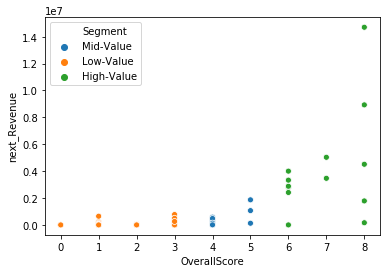

In [77]:
sns.scatterplot(x="OverallScore", y="next_Revenue", data=fs_merge, hue="Segment")

In [78]:
#remove outliers
fs_merge = fs_merge[fs_merge['next_Revenue']<fs_merge['next_Revenue'].quantile(0.99)]


#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(fs_merge[['next_Revenue']])
fs_merge['LTVCluster'] = kmeans.predict(fs_merge[['next_Revenue']])

#order cluster number based on LTV
fs_merge = order_cluster('LTVCluster', 'next_Revenue',fs_merge,True)

#creatinga new cluster dataframe
fs_cluster = fs_merge.copy()

#see details of the clusters
fs_cluster.groupby('LTVCluster')['next_Revenue'].describe()

count          mean            std           min           25%  \
LTVCluster                                                                   
0            97.0  6.566485e+04  178937.182252  0.000000e+00  0.000000e+00   
1             5.0  2.346670e+06  508542.662458  1.784269e+06  1.865741e+06   
2             5.0  4.068222e+06  712817.074169  3.330749e+06  3.467638e+06   

                     50%           75%           max  
LTVCluster                                            
0           0.000000e+00  4.086656e+03  1.062901e+06  
1           2.411297e+06  2.792633e+06  2.879413e+06  
2           4.000059e+06  4.512017e+06  5.030649e+06

In [79]:
#convert categorical columns to numerical
fs_class = pd.get_dummies(fs_cluster)

#calculate and show correlations
corr_matrix = fs_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

#create X and y, X will be feature set and y is the label - LTV
X = fs_class.drop(['LTVCluster','next_Revenue'],axis=1)
y = fs_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
X_test

Recency  RecencyCluster  Frequency  FrequencyCluster       Revenue  \
76       745               0          9                 0  1.654663e+03   
10        80               3        117                 0  4.639988e+04   
4         17               3        778                 1  7.796661e+05   
99        21               3       3395                 2  2.788584e+06   
70       765               0         53                 0  2.307354e+05   
66       765               0        340                 0  5.188734e+05   
30       318               2        136                 0  8.662645e+04   
45       680               1         33                 0  1.140130e+04   
94       207               2        495                 0  2.235992e+06   
11        52               3        110                 0  2.415861e+04   
78       988               0          1                 0  3.253325e+02   
47       504               1          8                 0  9.279977e+02   
0         37               3       1239                 1  8.879391e+05   
79       981               0         81                 0  1.154397e+04   
18        98               3          1                 0  3.333325e+02   
105        3               3       7052                 3  6.060584e+06   
55       618               1         26                 0  1.052264e+04   
77       994               0         16                 0  1.146664e+03   
65       443               1          1                 0  4.159990e+02   
42       456               1        166                 0  2.673767e+05   
12        10               3         25                 0  1.434663e+04   
36       273               2          1                 0  2.788260e+04   

     RevenueCluster  OverallScore  CustId_cust_id_1037  CustId_cust_id_1044  \
76                0             0                    0                    0   
10                0             3                    0                    0   
4                 0             4                    0                    0   
99                1             6                    0                    0   
70                0             0                    0                    0   
66                0             0                    0                    0   
30                0             2                    0                    0   
45                0             1                    0                    0   
94                1             3                    0                    0   
11                0             3                    0                    0   
78                0             0                    0                    0   
47                0             1                    0                    0   
0                 0             4                    0                    0   
79                0             0                    0                    0   
18                0             3                    0                    0   
105               2             8                    0                    0   
55                0             1                    0                    0   
77                0             0                    0                    0   
65                0             1                    0                    0   
42                0             1                    0                    0   
12                0             3                    0                    0   
36                0             2                    0                    0   

     CustId_cust_id_1110  ...  CustId_cust_id_674  CustId_cust_id_804  \
76                     0  ...                   0                   0   
10                     0  ...                   0                   0   
4                      0  ...                   0                   0   
99                     0  ...                   0                   0   
70                     0  ...                   0                   0   
66                     

In [81]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [82]:
len(X_test)

22

In [83]:
# XGBoost Multiclassification Model
import xgboost as xgb
from sklearn.metrics import classification_report
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.01,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.95
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.00      0.00      0.00         1
           2       0.50      1.00      0.67         1

    accuracy                           0.95        22
   macro avg       0.50      0.67      0.56        22
weighted avg       0.93      0.95      0.94        22



In [84]:
# Random Forrest Multiclassification Model
from sklearn.ensemble import RandomForestClassifier

ltv_rf_model = RandomForestClassifier(n_estimators = 1000,criterion = 'entropy', random_state = 42).fit(X_train, y_train)

print('Accuracy of RF classifier on training set: {:.2f}'
       .format(ltv_rf_model.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
       .format(ltv_rf_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of RF classifier on training set: 1.00
Accuracy of RF classifier on test set: 0.95
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.00      0.00      0.00         1
           2       0.50      1.00      0.67         1

    accuracy                           0.95        22
   macro avg       0.50      0.67      0.56        22
weighted avg       0.93      0.95      0.94        22



In [85]:
# from sklearn.svm import SVC

# ltv_svc_model = SVC(kernel='linear', random_state = 42).fit(X_train, y_train)

# print('Accuracy of RF classifier on training set: {:.2f}'
#        .format(ltv_svc_model.score(X_train, y_train)))
# print('Accuracy of RF classifier on test set: {:.2f}'
#        .format(ltv_svc_model.score(X_test[X_train.columns], y_test)))

# y_pred = svclassifier.predict(X_test)
# print(classification_report(y_test, y_pred))

In [86]:
#Predict next purchase

In [87]:
fs_prev = sales[(sales.Date >= date(2014,1,1)) & (sales.Date < date(2017,1,1))].reset_index(drop=True)
fs_next = sales[(sales.Date >= date(2017,1,1)) & (sales.Date < date(2019,12,31))].reset_index(drop=True)

In [88]:
fs_user = pd.DataFrame(fs_prev['CustId'].unique())
fs_user.columns = ['CustId']
fs_user

CustId
0    cust_id_2558
1    cust_id_1549
2    cust_id_3970
3     cust_id_190
4    cust_id_4253
..            ...
104   cust_id_413
105  cust_id_1198
106  cust_id_3726
107  cust_id_2452
108  cust_id_2203

[109 rows x 1 columns]

In [89]:
#create a dataframe with customer id and first purchase date in fs_next
fs_next_first_purchase = fs_next.groupby('CustId').Date.min().reset_index()
fs_next_first_purchase.columns = ['CustId','MinPurchaseDate']

#create a dataframe with customer id and last purchase date in fs_next
fs_last_purchase = fs_prev.groupby('CustId').Date.max().reset_index()
fs_last_purchase.columns = ['CustId','MaxPurchaseDate']

#merge two dataframes
fs_purchase_dates = pd.merge(fs_last_purchase,fs_next_first_purchase,on='CustId',how='left')

#calculate the time difference in days:
fs_purchase_dates['NextPurchaseDay'] = (fs_purchase_dates['MinPurchaseDate'] - fs_purchase_dates['MaxPurchaseDate']).dt.days

#merge with fs_user 
fs_user = pd.merge(fs_user, fs_purchase_dates[['CustId','NextPurchaseDay']],on='CustId',how='left')

#print fs_user
fs_user.head()

#fill NA values with 999
fs_user = fs_user.fillna(999)
fs_user

CustId  NextPurchaseDay
0    cust_id_2558            103.0
1    cust_id_1549              8.0
2    cust_id_3970             16.0
3     cust_id_190             75.0
4    cust_id_4253            472.0
..            ...              ...
104   cust_id_413            999.0
105  cust_id_1198            999.0
106  cust_id_3726            999.0
107  cust_id_2452            999.0
108  cust_id_2203            999.0

[109 rows x 2 columns]

In [90]:
#create a dataframe with CustomerID and Invoice Date
fs_day_order = fs_prev[['CustId','Date']]
#convert Invoice Datetime to day
fs_day_order['InvoiceDay'] = fs_prev['Date'].dt.date
fs_day_order = fs_day_order.sort_values(['CustId','Date'])
#drop duplicates
fs_day_order = fs_day_order.drop_duplicates(subset=['CustId','InvoiceDay'],keep='first')
fs_day_order

CustId       Date  InvoiceDay
67558  cust_id_1037 2015-05-26  2015-05-26
62952  cust_id_1044 2014-01-28  2014-01-28
62956  cust_id_1044 2016-04-14  2016-04-14
62972  cust_id_1044 2016-06-16  2016-06-16
66575  cust_id_1110 2015-04-17  2015-04-17
...             ...        ...         ...
46129   cust_id_925 2015-03-30  2015-03-30
46810   cust_id_925 2016-09-22  2016-09-22
66574   cust_id_928 2014-04-17  2014-04-17
65180   cust_id_963 2016-02-19  2016-02-19
64870   cust_id_996 2014-02-05  2014-02-05

[1471 rows x 3 columns]

In [91]:
#shifting last 3 purchase dates
fs_day_order['PrevInvoiceDate'] = fs_day_order.groupby('CustId')['InvoiceDay'].shift(1)
fs_day_order['T2InvoiceDate'] = fs_day_order.groupby('CustId')['InvoiceDay'].shift(2)
fs_day_order['T3InvoiceDate'] = fs_day_order.groupby('CustId')['InvoiceDay'].shift(3)

In [92]:
fs_day_order['DayDiff'] = (fs_day_order['InvoiceDay'] - fs_day_order['PrevInvoiceDate']).dt.days
fs_day_order['DayDiff2'] = (fs_day_order['InvoiceDay'] - fs_day_order['T2InvoiceDate']).dt.days
fs_day_order['DayDiff3'] = (fs_day_order['InvoiceDay'] - fs_day_order['T3InvoiceDate']).dt.days

In [93]:
fs_day_diff = fs_day_order.groupby('CustId').agg({'DayDiff': ['mean','std']}).reset_index()
fs_day_diff.columns = ['CustId', 'DayDiffMean','DayDiffStd']
fs_day_diff

CustId  DayDiffMean  DayDiffStd
0    cust_id_1037          NaN         NaN
1    cust_id_1044        435.0  526.087445
2    cust_id_1110         52.0         NaN
3    cust_id_1140          NaN         NaN
4    cust_id_1198          NaN         NaN
..            ...          ...         ...
104   cust_id_849          6.0         NaN
105   cust_id_925         43.0  110.412038
106   cust_id_928          NaN         NaN
107   cust_id_963          NaN         NaN
108   cust_id_996          NaN         NaN

[109 rows x 3 columns]

In [94]:
fs_day_order_last = fs_day_order.drop_duplicates(subset=['CustId'],keep='last')

In [95]:
fs_day_order_last = fs_day_order_last.dropna()

In [96]:
fs_day_order_last

CustId       Date  InvoiceDay PrevInvoiceDate T2InvoiceDate  \
64855  cust_id_1327 2015-06-23  2015-06-23      2015-06-04    2015-05-15   
65999  cust_id_1456 2016-04-15  2016-04-15      2016-03-21    2015-11-30   
8264   cust_id_1549 2016-12-27  2016-12-27      2016-12-14    2016-12-13   
58247  cust_id_1556 2016-12-06  2016-12-06      2016-11-09    2016-07-13   
23822  cust_id_1626 2016-12-28  2016-12-28      2016-12-21    2016-12-16   
31771  cust_id_1685 2016-09-27  2016-09-27      2016-04-27    2016-04-05   
65534  cust_id_1753 2014-11-26  2014-11-26      2014-10-28    2014-09-18   
17109   cust_id_190 2016-12-30  2016-12-30      2016-12-09    2016-11-18   
61200  cust_id_1987 2016-11-15  2016-11-15      2016-11-01    2016-10-18   
63049  cust_id_2313 2014-10-16  2014-10-16      2014-10-14    2014-09-11   
53898  cust_id_2332 2016-05-04  2016-05-04      2016-01-19    2015-09-16   
44669  cust_id_2432 2016-01-22  2016-01-22      2016-01-06    2015-10-21   
64088  cust_id_2483 2016-10-24  2016-10-24      2016-09-24    2016-08-29   
1238   cust_id_2558 2016-11-23  2016-11-23      2016-11-18    2016-10-14   
31281  cust_id_2700 2016-12-09  2016-12-09      2016-12-08    2016-11-23   
50194  cust_id_2766 2016-10-11  2016-10-11      2016-08-15    2016-03-15   
51502  cust_id_2774 2016-03-02  2016-03-02      2016-02-26    2016-02-18   
26744  cust_id_2831 2016-07-25  2016-07-25      2016-04-20    2016-01-04   
59895  cust_id_3001 2016-12-13  2016-12-13      2016-11-30    2016-11-22   
27887  cust_id_3106 2016-12-19  2016-12-19      2016-12-13    2016-08-31   
61552  cust_id_3252 2015-10-01  2015-10-01      2015-07-29    2015-05-04   
66474  cust_id_3254 2016-11-18  2016-11-18      2016-06-16    2016-06-03   
59073  cust_id_3305 2016-12-13  2016-12-13      2016-11-03    2016-10-12   
65567  cust_id_3551 2015-03-12  2015-03-12      2014-10-23    2014-05-29   
18128  cust_id_3856 2016-08-30  2016-08-30      2016-08-02    2016-07-28   
53890  cust_id_3857 2016-12-21  2016-12-21      2016-12-19    2016-12-05   
38419  cust_id_3902 2016-12-16  2016-12-16      2016-12-14    2016-12-02   
26217  cust_id_3936 2016-12-20  2016-12-20      2016-12-13    2016-11-15   
65044  cust_id_3957 2016-02-16  2016-02-16      2015-06-29    2015-06-26   
15809  cust_id_3970 2016-12-19  2016-12-19      2016-12-15    2016-12-09   
49962  cust_id_4020 2016-12-29  2016-12-29      2016-12-16    2016-12-14   
56046  cust_id_4094 2016-12-14  2016-12-14      2016-10-07    2016-08-29   
66945  cust_id_4133 2016-08-12  2016-08-12      2016-06-22    2016-06-15   
36592  cust_id_4196 2016-12-27  2016-12-27      2016-12-20    2016-12-08   
17595  cust_id_4253 2016-06-06  2016-06-06      2016-03-28    2015-10-14   
61382  cust_id_4270 2016-05-13  2016-05-13      2015-09-09    2015-08-17   
62928   cust_id_460 2015-02-19  2015-02-19      2014-09-25    2014-02-21   
61352   cust_id_644 2016-06-27  2016-06-27      2016-05-31    2016-05-09   
44365   cust_id_674 2016-12-19  2016-12-19      2016-11-28    2016-11-17   
46810   cust_id_925 2016-09-22  2016-09-22      2015-03-30    2015-03-09   

      T3InvoiceDate  DayDiff  DayDiff2  DayDiff3  
64855    2015-04-28     19.0      39.0      56.0  
65999    2015-04-13     25.0     137.0     368.0  
8264     2016-11-30     13.0      14.0      27.0  
58247    2016-07-06     27.0     146.0     153.0  
23822    2016-12-15      7.0      12.0      13.0  
31771    2016-01-04    153.0     175.0     267.0  
65534    2014-06-20     29.0      69.0     159.0  
17109    2016-10-31     21.0      42.0      60.0  
61200    2016-09-21     14.0      28.0      55.0  
63049    2014-07-02      2.0      35.0     106.0  
53898    2015-07-20    106.0     231.0     289.0  
44669    2015-10-07     16.0      93.0     107.0  
64088    2016-07-20     30.0      56.0      96.0  
1238     2016-09-13      5.0      40.0      71.0  
31281    2016-10-20      1.0      16.0      50.0  
50194    2016-02-26     57.0     210.0     228.0  
51502    2016-02-12      5.0 

In [97]:
fs_day_order_last = pd.merge(fs_day_order_last, fs_day_diff, on='CustId')
fs_day_order_last

CustId       Date  InvoiceDay PrevInvoiceDate T2InvoiceDate  \
0   cust_id_1327 2015-06-23  2015-06-23      2015-06-04    2015-05-15   
1   cust_id_1456 2016-04-15  2016-04-15      2016-03-21    2015-11-30   
2   cust_id_1549 2016-12-27  2016-12-27      2016-12-14    2016-12-13   
3   cust_id_1556 2016-12-06  2016-12-06      2016-11-09    2016-07-13   
4   cust_id_1626 2016-12-28  2016-12-28      2016-12-21    2016-12-16   
5   cust_id_1685 2016-09-27  2016-09-27      2016-04-27    2016-04-05   
6   cust_id_1753 2014-11-26  2014-11-26      2014-10-28    2014-09-18   
7    cust_id_190 2016-12-30  2016-12-30      2016-12-09    2016-11-18   
8   cust_id_1987 2016-11-15  2016-11-15      2016-11-01    2016-10-18   
9   cust_id_2313 2014-10-16  2014-10-16      2014-10-14    2014-09-11   
10  cust_id_2332 2016-05-04  2016-05-04      2016-01-19    2015-09-16   
11  cust_id_2432 2016-01-22  2016-01-22      2016-01-06    2015-10-21   
12  cust_id_2483 2016-10-24  2016-10-24      2016-09-24    2016-08-29   
13  cust_id_2558 2016-11-23  2016-11-23      2016-11-18    2016-10-14   
14  cust_id_2700 2016-12-09  2016-12-09      2016-12-08    2016-11-23   
15  cust_id_2766 2016-10-11  2016-10-11      2016-08-15    2016-03-15   
16  cust_id_2774 2016-03-02  2016-03-02      2016-02-26    2016-02-18   
17  cust_id_2831 2016-07-25  2016-07-25      2016-04-20    2016-01-04   
18  cust_id_3001 2016-12-13  2016-12-13      2016-11-30    2016-11-22   
19  cust_id_3106 2016-12-19  2016-12-19      2016-12-13    2016-08-31   
20  cust_id_3252 2015-10-01  2015-10-01      2015-07-29    2015-05-04   
21  cust_id_3254 2016-11-18  2016-11-18      2016-06-16    2016-06-03   
22  cust_id_3305 2016-12-13  2016-12-13      2016-11-03    2016-10-12   
23  cust_id_3551 2015-03-12  2015-03-12      2014-10-23    2014-05-29   
24  cust_id_3856 2016-08-30  2016-08-30      2016-08-02    2016-07-28   
25  cust_id_3857 2016-12-21  2016-12-21      2016-12-19    2016-12-05   
26  cust_id_3902 2016-12-16  2016-12-16      2016-12-14    2016-12-02   
27  cust_id_3936 2016-12-20  2016-12-20      2016-12-13    2016-11-15   
28  cust_id_3957 2016-02-16  2016-02-16      2015-06-29    2015-06-26   
29  cust_id_3970 2016-12-19  2016-12-19      2016-12-15    2016-12-09   
30  cust_id_4020 2016-12-29  2016-12-29      2016-12-16    2016-12-14   
31  cust_id_4094 2016-12-14  2016-12-14      2016-10-07    2016-08-29   
32  cust_id_4133 2016-08-12  2016-08-12      2016-06-22    2016-06-15   
33  cust_id_4196 2016-12-27  2016-12-27      2016-12-20    2016-12-08   
34  cust_id_4253 2016-06-06  2016-06-06      2016-03-28    2015-10-14   
35  cust_id_4270 2016-05-13  2016-05-13      2015-09-09    2015-08-17   
36   cust_id_460 2015-02-19  2015-02-19      2014-09-25    2014-02-21   
37   cust_id_644 2016-06-27  2016-06-27      2016-05-31    2016-05-09   
38   cust_id_674 2016-12-19  2016-12-19      2016-11-28    2016-11-17   
39   cust_id_925 2016-09-22  2016-09-22      2015-03-30    2015-03-09   

   T3InvoiceDate  DayDiff  DayDiff2  DayDiff3  DayDiffMean  DayDiffStd  
0     2015-04-28     19.0      39.0      56.0    18.666667    1.527525  
1     2015-04-13     25.0     137.0     368.0   122.666667  103.413410  
2     2016-11-30     13.0      14.0      27.0    10.686275    9.311954  
3     2016-07-06     27.0     146.0     153.0    24.045455   29.867891  
4     2016-12-15      7.0      12.0      13.0     8.036364   27.690268  
5     2016-01-04    153.0     175.0     267.0   155.000000  149.015435  
6     2014-06-20     29.0      69.0     159.0    64.750000   35.453021  
7     2016-10-31     21.0      42.0      60.0    22.306122   21.095225  
8     2016-09-21     14.0      28.0      55.0    23.312500   20.574707  
9     2014-07-02      2.0      35.0     106.0    65.000000   65.701344  
10    2015-07-20    106.0     231.0     289.0    49.764706   47.117578  
11    2015-10-07     16.0      93.0     107.0    11.074627   12.803070  
12    2016-07-20     30.0      56.0      96.0    34.703704   26.762

In [98]:
fs_cust = pd.merge(fs_user, fs_cust, on='CustId')
fs_cust

CustId  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
0    cust_id_2558            103.0       37               3       1239   
1    cust_id_1549              8.0        3               3       7052   
2    cust_id_3970             16.0       11               3       7568   
3     cust_id_190             75.0        0               3       1251   
4    cust_id_4253            472.0      207               2        495   
..            ...              ...      ...             ...        ...   
104   cust_id_413            999.0      791               0          9   
105  cust_id_1198            999.0      774               0          4   
106  cust_id_3726            999.0      402               2          4   
107  cust_id_2452            999.0       22               3          9   
108  cust_id_2203            999.0      745               0         49   

     FrequencyCluster       Revenue  RevenueCluster  OverallScore     Segment  
0                   1  8.879391e+05               0             4   Mid-Value  
1                   3  6.060584e+06               2             8  High-Value  
2                   3  6.539616e+06               2             8  High-Value  
3                   1  1.198006e+06               1             5   Mid-Value  
4                   0  2.235992e+06               1             3   Low-Value  
..                ...           ...             ...           ...         ...  
104                 0  1.471996e+03               0             0   Low-Value  
105                 0  8.106646e+02               0             0   Low-Value  
106                 0  3.999990e+02               0             2   Low-Value  
107                 0  4.824788e+04               0             3   Low-Value  
108                 0  7.348115e+04               0             0   Low-Value  

[109 rows x 10 columns]

In [99]:
fs_user2 = pd.merge(fs_cust, fs_day_order_last[['CustId','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustId')
#create fs_class as a copy of fs_user before applying get_dummies
fs_user2

CustId  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
0   cust_id_2558            103.0       37               3       1239   
1   cust_id_1549              8.0        3               3       7052   
2   cust_id_3970             16.0       11               3       7568   
3    cust_id_190             75.0        0               3       1251   
4   cust_id_4253            472.0      207               2        495   
5   cust_id_3856            126.0      122               3        636   
6   cust_id_1626              7.0        2               3       5634   
7   cust_id_3936             36.0       10               3       2343   
8   cust_id_2831            999.0      158               2        532   
9   cust_id_3106             45.0       11               3       1091   
10  cust_id_2700             35.0       21               3       3395   
11  cust_id_1685            149.0       94               3        473   
12  cust_id_4196             13.0        3               3       4818   
13  cust_id_3902             20.0       14               3       1943   
14   cust_id_674             21.0       11               3       6085   
15  cust_id_2432            999.0      343               2        860   
16   cust_id_925            999.0       99               3       1490   
17  cust_id_4020             29.0        1               3       3187   
18  cust_id_2766            119.0       80               3        117   
19  cust_id_2774            572.0      303               2       2391   
20  cust_id_3857             20.0        9               3       1228   
21  cust_id_2332            995.0      240               2        404   
22  cust_id_4094             57.0       16               3       1848   
23  cust_id_1556            105.0       24               3       2147   
24  cust_id_3305            134.0       17               3        829   
25  cust_id_3001             30.0       17               3        778   
26  cust_id_1987            118.0       45               3       1318   
27   cust_id_644            274.0      186               2        137   
28  cust_id_4270            250.0      231               2         32   
29  cust_id_3252            742.0      456               1        166   
30   cust_id_460            999.0      680               1         33   
31  cust_id_2313            999.0      806               0         52   
32  cust_id_2483            101.0       67               3       1365   
33  cust_id_1327            591.0      556               1        429   
34  cust_id_3957            421.0      318               2        136   
35  cust_id_1753            999.0      765               0         53   
36  cust_id_3551            999.0      659               1          7   
37  cust_id_1456            999.0      259               2        130   
38  cust_id_3254            999.0       42               3        166   
39  cust_id_4133            334.0      140               3        425   

    FrequencyCluster       Revenue  RevenueCluster  OverallScore     Segment  \
0                  1  8.879391e+05               0             4   Mid-Value   
1                  3  6.060584e+06               2             8  High-Value   
2                  3  6.539616e+06               2             8  High-Value   
3                  1  1.198006e+06               1             5   Mid-Value   
4                  0  2.235992e+06               1             3   Low-Value   
5                  1  2.851953e+05               0             4   Mid-Value   
6                  3  5.800524e+06               2             8  High-Value   
7                  2  1.433220e+06               1             6  High-Value   
8                  0  1.752982e+05               0             2   Low-Value   
9                  1  7.409168e+05               0             4   Mid-Value   
10                 2  2.788584e+06               1             6  High-Value   
11                 0  8.453712e+05               0      

In [100]:
fs_class = fs_user2.copy()
fs_class = pd.get_dummies(fs_class)
fs_class

NextPurchaseDay  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0             103.0       37               3       1239                 1   
1               8.0        3               3       7052                 3   
2              16.0       11               3       7568                 3   
3              75.0        0               3       1251                 1   
4             472.0      207               2        495                 0   
5             126.0      122               3        636                 1   
6               7.0        2               3       5634                 3   
7              36.0       10               3       2343                 2   
8             999.0      158               2        532                 0   
9              45.0       11               3       1091                 1   
10             35.0       21               3       3395                 2   
11            149.0       94               3        473                 0   
12             13.0        3               3       4818                 3   
13             20.0       14               3       1943                 2   
14             21.0       11               3       6085                 3   
15            999.0      343               2        860                 1   
16            999.0       99               3       1490                 1   
17             29.0        1               3       3187                 2   
18            119.0       80               3        117                 0   
19            572.0      303               2       2391                 2   
20             20.0        9               3       1228                 1   
21            995.0      240               2        404                 0   
22             57.0       16               3       1848                 2   
23            105.0       24               3       2147                 2   
24            134.0       17               3        829                 1   
25             30.0       17               3        778                 1   
26            118.0       45               3       1318                 1   
27            274.0      186               2        137                 0   
28            250.0      231               2         32                 0   
29            742.0      456               1        166                 0   
30            999.0      680               1         33                 0   
31            999.0      806               0         52                 0   
32            101.0       67               3       1365                 1   
33            591.0      556               1        429                 0   
34            421.0      318               2        136                 0   
35            999.0      765               0         53                 0   
36            999.0      659               1          7                 0   
37            999.0      259               2        130                 0   
38            999.0       42               3        166                 0   
39            334.0      140               3        425                 0   

         Revenue  RevenueCluster  OverallScore  DayDiff  DayDiff2  ...  \
0   8.879391e+05               0             4      5.0      40.0  ...   
1   6.060584e+06               2             8     13.0      14.0  ...   
2   6.539616e+06               2             8      4.0      10.0  ...   
3   1.198006e+06               1             5     21.0      42.0  ...   
4   2.235992e+06               1             3     70.0     236.0  ...   
5   2.851953e+05               0             4     28.0      33.0  ...   
6   5.800524e+06               2             8      7.0      12.0  ...   
7   1.433220e+06               1             6      7.0      35.0  ...   
8   1.752982e+05               0             2     96.0     203.0  ...   
9   7.409168e+05               0             4      6.0     110.0  ...   
10  2.788584e+06               1

In [101]:
fs_class['NextPurchaseDayRange'] = 2
fs_class.loc[fs_class.NextPurchaseDay>50,'NextPurchaseDayRange'] = 1
fs_class.loc[fs_class.NextPurchaseDay>200,'NextPurchaseDayRange'] = 0

In [102]:
fs_class

NextPurchaseDay  Recency  RecencyCluster  Frequency  FrequencyCluster  \
0             103.0       37               3       1239                 1   
1               8.0        3               3       7052                 3   
2              16.0       11               3       7568                 3   
3              75.0        0               3       1251                 1   
4             472.0      207               2        495                 0   
5             126.0      122               3        636                 1   
6               7.0        2               3       5634                 3   
7              36.0       10               3       2343                 2   
8             999.0      158               2        532                 0   
9              45.0       11               3       1091                 1   
10             35.0       21               3       3395                 2   
11            149.0       94               3        473                 0   
12             13.0        3               3       4818                 3   
13             20.0       14               3       1943                 2   
14             21.0       11               3       6085                 3   
15            999.0      343               2        860                 1   
16            999.0       99               3       1490                 1   
17             29.0        1               3       3187                 2   
18            119.0       80               3        117                 0   
19            572.0      303               2       2391                 2   
20             20.0        9               3       1228                 1   
21            995.0      240               2        404                 0   
22             57.0       16               3       1848                 2   
23            105.0       24               3       2147                 2   
24            134.0       17               3        829                 1   
25             30.0       17               3        778                 1   
26            118.0       45               3       1318                 1   
27            274.0      186               2        137                 0   
28            250.0      231               2         32                 0   
29            742.0      456               1        166                 0   
30            999.0      680               1         33                 0   
31            999.0      806               0         52                 0   
32            101.0       67               3       1365                 1   
33            591.0      556               1        429                 0   
34            421.0      318               2        136                 0   
35            999.0      765               0         53                 0   
36            999.0      659               1          7                 0   
37            999.0      259               2        130                 0   
38            999.0       42               3        166                 0   
39            334.0      140               3        425                 0   

         Revenue  RevenueCluster  OverallScore  DayDiff  DayDiff2  ...  \
0   8.879391e+05               0             4      5.0      40.0  ...   
1   6.060584e+06               2             8     13.0      14.0  ...   
2   6.539616e+06               2             8      4.0      10.0  ...   
3   1.198006e+06               1             5     21.0      42.0  ...   
4   2.235992e+06               1             3     70.0     236.0  ...   
5   2.851953e+05               0             4     28.0      33.0  ...   
6   5.800524e+06               2             8      7.0      12.0  ...   
7   1.433220e+06               1             6      7.0      35.0  ...   
8   1.752982e+05               0             2     96.0     203.0  ...   
9   7.409168e+05               0             4      6.0     110.0  ...   
10  2.788584e+06               1

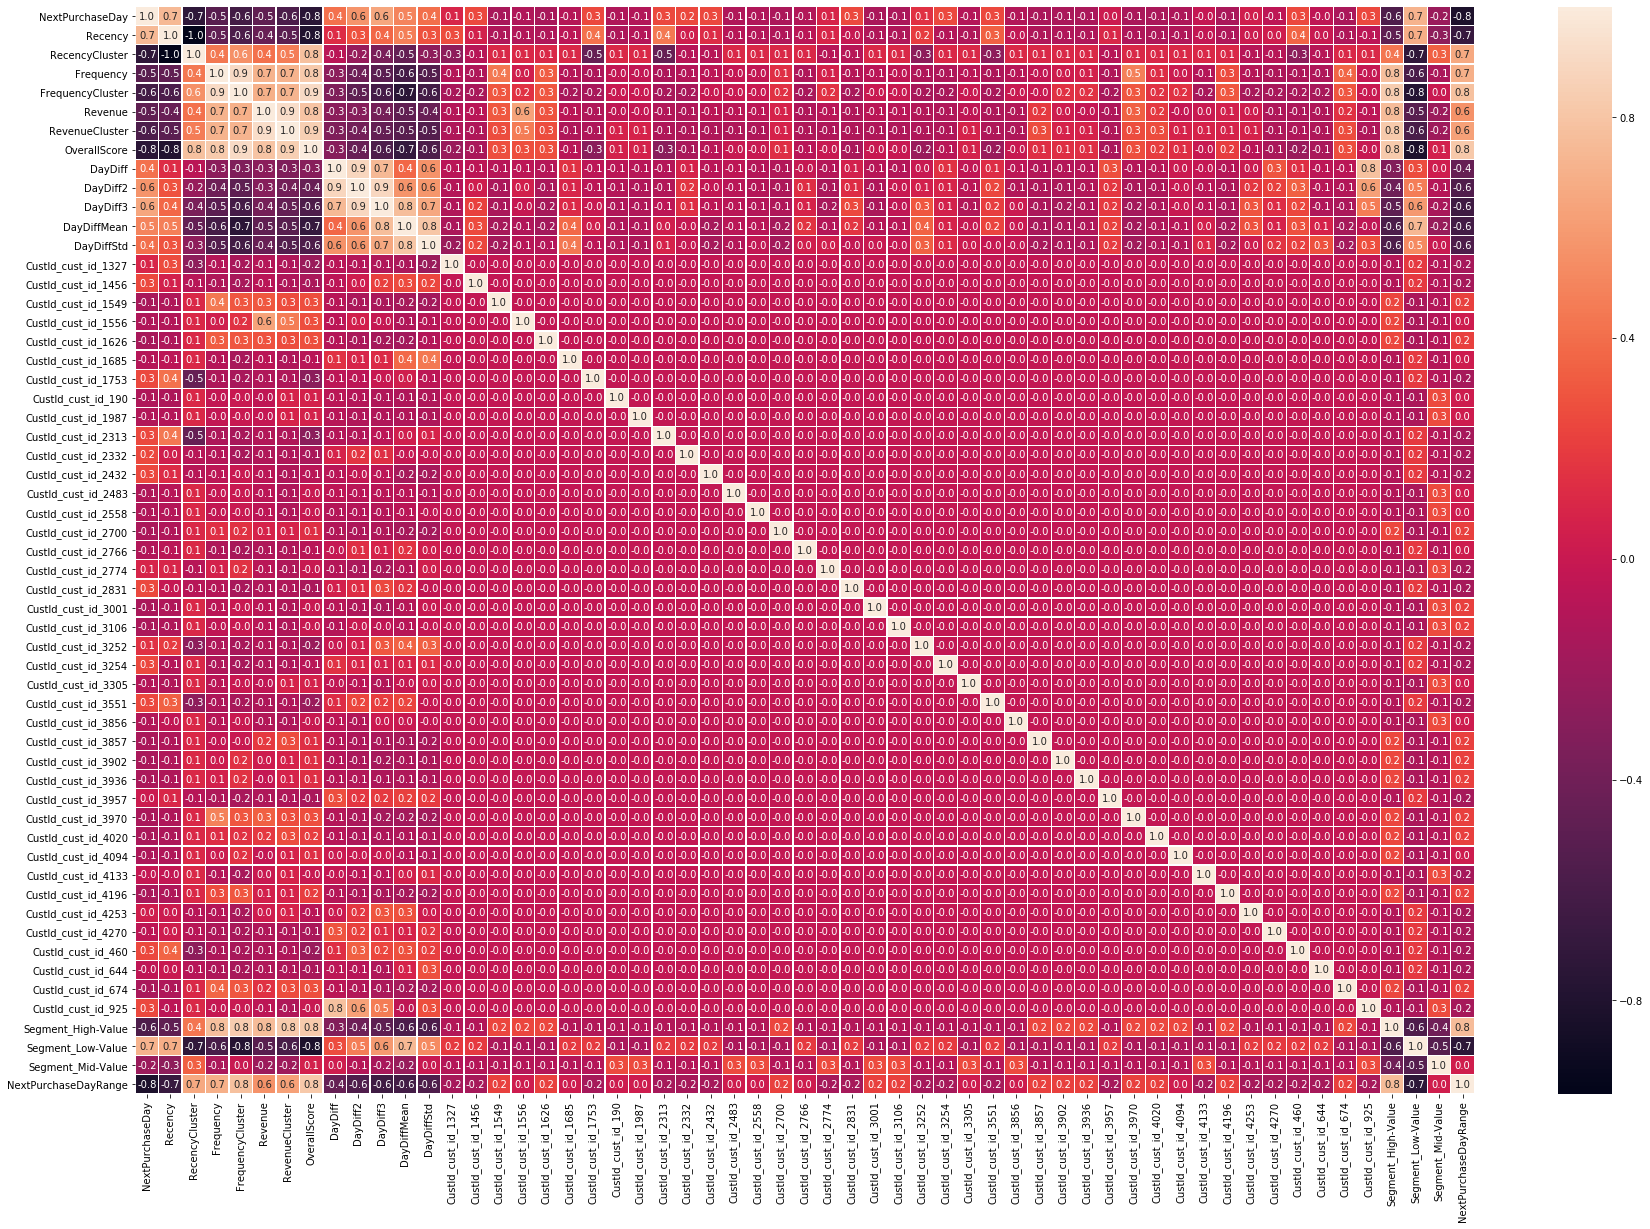

In [103]:
corr = fs_class[fs_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".1f")

In [104]:
#train & test split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#fs_class = fs_class.drop('NextPurchaseDay',axis=1)

X, y = fs_class.drop('NextPurchaseDayRange',axis=1), fs_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.6875 0.6875]
NB [0.8125 0.8125]
RF [0.9375 0.75  ]
SVC [0.375  0.3125]
Dtree [0.75  0.875]
XGB [0.8125 0.875 ]
KNN [0.625  0.6875]


In [105]:
sales.head(5)

Date          OrderNumber  OrderLineNumber  Quantity  SellPrice  \
211573 2014-01-02  order_number_218558               20         2    1.33333   
211574 2014-01-02  order_number_218558               20         2   81.33313   
211575 2014-01-02  order_number_218558               20         1   78.66647   
211576 2014-01-02  order_number_218558               20         1   35.99991   
211577 2014-01-02  order_number_218558               20         2  167.99958   

              CCN         PartnerNumber Material ItemCategoryGroup  \
211573  ccn_20737  partner_number_73578  mat_427    item_cat_grp_3   
211574  ccn_20737  partner_number_73578  mat_427    item_cat_grp_3   
211575  ccn_20737  partner_number_73578  mat_427    item_cat_grp_3   
211576  ccn_20737  partner_number_73578  mat_427    item_cat_grp_3   
211577  ccn_20737  partner_number_73578  mat_427    item_cat_grp_3   

       ItemCategory  ...   PlantType     PlantPlatform           Market  \
211573   item_cat_6  ...  Unassigned  plant_platform_1  Water Resources   
211574   item_cat_6  ...  Unassigned  plant_platform_1  Water Resources   
211575   item_cat_6  ...  Unassigned  plant_platform_1  Water Resources   
211576   item_cat_6  ...  Unassigned  plant_platform_1  Water Resources   
211577   item_cat_6  ...  Unassigned  plant_platform_1  Water Resources   

       MonthYear Column 32 InvoiceYearMonth    Revenue MinPurchaseDate  \
211573   01/2014       NaN           201401    2.66666      2014-01-02   
211574   01/2014       NaN           201401  162.66626      2014-01-02   
211575   01/2014       NaN           201401   78.66647      2014-01-02   
211576   01/2014       NaN           201401   35.99991      2014-01-02   
211577   01/2014       NaN           201401  335.99916      2014-01-02   

       MinPurchaseYearMonth UserType  
211573               201401      New  
211574               201401      New  
211575               201401      New  
211576               201401      New  
211577               201401      New  

[5 rows x 37 columns]

In [106]:
#####  Churnnnnnnnnnn

In [107]:
#converting the type of Invoice Date Field from string to datetime.
sales['Date'] = pd.to_datetime(sales['Date'])

cust_group = sales.groupby(['CustId','Date','PostalCode'])['SellPrice'].sum().reset_index()

In [108]:
list(sales.columns) 

['Date',
 'OrderNumber',
 'OrderLineNumber',
 'Quantity',
 'SellPrice',
 'CCN',
 'PartnerNumber',
 'Material',
 'ItemCategoryGroup',
 'ItemCategory',
 'ItemDescription',
 'ProductCode',
 'ProductDescription',
 'NounCodeDescription',
 'NounCode',
 'ShipFrom',
 'CustomerName',
 'CustId',
 'City',
 'State',
 'PostalCode',
 'Country',
 'Region',
 'SubRegion',
 'Industry',
 'IndustryGroup',
 'Plant',
 'PlantType',
 'PlantPlatform',
 'Market',
 'MonthYear',
 'Column 32',
 'InvoiceYearMonth',
 'Revenue',
 'MinPurchaseDate',
 'MinPurchaseYearMonth',
 'UserType']

In [109]:
cust_group

CustId       Date PostalCode    SellPrice
0     cust_id_1037 2015-05-26       8901    807.99798
1     cust_id_1044 2014-01-28      32934   5269.32016
2     cust_id_1044 2016-04-14      32934  31050.58904
3     cust_id_1044 2016-06-16      32934  55279.86180
4     cust_id_1044 2017-05-23      32934      7.99998
...            ...        ...        ...          ...
2592   cust_id_946 2017-08-01      11200   2079.99480
2593   cust_id_946 2017-09-22      11200     23.99994
2594   cust_id_946 2018-02-01      11200    399.99900
2595   cust_id_963 2016-02-19      48933    114.66638
2596   cust_id_996 2014-02-05      33801    809.33131

[2597 rows x 4 columns]

In [110]:
frequency = cust_group.groupby('CustId').Date.count().reset_index()
frequency.columns = ['CustId','frequency']

In [111]:
max_purchase = cust_group.groupby('CustId').Date.max().reset_index()
min_purchase = cust_group.groupby('CustId').Date.min().reset_index()
max_purchase.columns = ['CustId','max_purchase']
min_purchase.columns = ['CustId','min_purchase']

In [112]:
frequency

CustId  frequency
0    cust_id_1037          1
1    cust_id_1044          6
2    cust_id_1072          1
3    cust_id_1110          2
4    cust_id_1140          1
..            ...        ...
127   cust_id_925         24
128   cust_id_928          1
129   cust_id_946          6
130   cust_id_963          1
131   cust_id_996          1

[132 rows x 2 columns]

In [113]:
fs = pd.merge(frequency,min_purchase,on='CustId',how='left')
fs = pd.merge(fs,max_purchase,on='CustId',how='left')

In [114]:
fs['Period'] = (fs['max_purchase'] - fs['min_purchase']).dt.days
fs

CustId  frequency min_purchase max_purchase  Period
0    cust_id_1037          1   2015-05-26   2015-05-26       0
1    cust_id_1044          6   2014-01-28   2018-02-09    1473
2    cust_id_1072          1   2018-11-29   2018-11-29       0
3    cust_id_1110          2   2015-04-17   2015-06-08      52
4    cust_id_1140          1   2015-02-09   2015-02-09       0
..            ...        ...          ...          ...     ...
127   cust_id_925         24   2014-01-07   2016-09-22     989
128   cust_id_928          1   2014-04-17   2014-04-17       0
129   cust_id_946          6   2017-02-02   2018-02-01     364
130   cust_id_963          1   2016-02-19   2016-02-19       0
131   cust_id_996          1   2014-02-05   2014-02-05       0

[132 rows x 5 columns]

In [115]:
# remove one time purchaces
fs=fs.loc[fs['frequency'] > 10]


In [116]:
fs['rate'] = fs['frequency']/fs['Period']
fs.loc[~np.isfinite(fs['rate']), 'rate'] = np.nan
fs

CustId  frequency min_purchase max_purchase  Period      rate
13   cust_id_1327         13   2015-04-28   2019-04-02    1435  0.009059
21   cust_id_1549        177   2014-01-02   2019-04-24    1938  0.091331
23   cust_id_1556         53   2014-01-13   2019-01-15    1828  0.028993
25   cust_id_1626        267   2014-07-28   2019-05-07    1744  0.153096
26   cust_id_1685         15   2014-03-12   2018-09-10    1643  0.009130
33    cust_id_190         97   2014-01-02   2019-04-09    1923  0.050442
36   cust_id_1987         64   2014-10-31   2019-04-23    1635  0.039144
44   cust_id_2332         19   2014-01-09   2019-01-24    1841  0.010320
47   cust_id_2432         68   2014-01-10   2016-01-22     742  0.091644
49   cust_id_2483         35   2014-04-01   2018-08-21    1603  0.021834
52   cust_id_2558         59   2014-01-02   2019-04-05    1919  0.030745
55   cust_id_2700        129   2014-01-15   2019-05-07    1938  0.066563
57   cust_id_2766         25   2015-06-17   2019-05-02    1415  0.017668
58   cust_id_2774         28   2014-09-26   2018-01-30    1222  0.022913
66   cust_id_3001         58   2014-02-27   2019-03-12    1839  0.031539
69   cust_id_3106         48   2014-04-14   2019-04-26    1838  0.026115
71   cust_id_3252         11   2014-07-14   2019-01-24    1655  0.006647
75   cust_id_3305         32   2014-02-18   2019-03-26    1862  0.017186
88   cust_id_3856         30   2015-06-11   2019-04-24    1413  0.021231
89   cust_id_3857         83   2016-02-26   2019-03-11    1109  0.074842
91   cust_id_3902        123   2014-01-15   2019-05-02    1933  0.063632
92   cust_id_3936        112   2014-02-11   2019-04-17    1891  0.059228
95   cust_id_3970        301   2014-01-02   2019-05-06    1950  0.154359
97   cust_id_4020        100   2014-01-13   2019-04-10    1913  0.052274
99   cust_id_4094         64   2014-01-09   2019-03-15    1891  0.033845
101  cust_id_4133         14   2014-08-12   2017-07-18    1071  0.013072
105  cust_id_4196        188   2014-01-07   2019-05-06    1945  0.096658
108  cust_id_4253         13   2014-04-28   2019-03-14    1781  0.007299
119   cust_id_644         14   2014-01-29   2017-03-28    1154  0.012132
121   cust_id_674        110   2014-01-07   2017-11-13    1406  0.078236
127   cust_id_925         24   2014-01-07   2016-09-22     989  0.024267

In [117]:
fs.describe()

frequency       Period       rate
count   31.000000    31.000000  31.000000
mean    76.580645  1627.935484   0.045660
std     73.216016   341.002046   0.039658
min     11.000000   742.000000   0.006647
25%     24.500000  1414.000000   0.017427
50%     58.000000  1781.000000   0.030745
75%    105.000000  1902.000000   0.065098
max    301.000000  1950.000000   0.154359

In [118]:
ave=fs["rate"].mean()

In [119]:
fs['observed'] = np.where(fs['rate']>=ave, '0', '1')
# 0 no death yet

In [120]:
fs

CustId  frequency min_purchase max_purchase  Period      rate  \
13   cust_id_1327         13   2015-04-28   2019-04-02    1435  0.009059   
21   cust_id_1549        177   2014-01-02   2019-04-24    1938  0.091331   
23   cust_id_1556         53   2014-01-13   2019-01-15    1828  0.028993   
25   cust_id_1626        267   2014-07-28   2019-05-07    1744  0.153096   
26   cust_id_1685         15   2014-03-12   2018-09-10    1643  0.009130   
33    cust_id_190         97   2014-01-02   2019-04-09    1923  0.050442   
36   cust_id_1987         64   2014-10-31   2019-04-23    1635  0.039144   
44   cust_id_2332         19   2014-01-09   2019-01-24    1841  0.010320   
47   cust_id_2432         68   2014-01-10   2016-01-22     742  0.091644   
49   cust_id_2483         35   2014-04-01   2018-08-21    1603  0.021834   
52   cust_id_2558         59   2014-01-02   2019-04-05    1919  0.030745   
55   cust_id_2700        129   2014-01-15   2019-05-07    1938  0.066563   
57   cust_id_2766         25   2015-06-17   2019-05-02    1415  0.017668   
58   cust_id_2774         28   2014-09-26   2018-01-30    1222  0.022913   
66   cust_id_3001         58   2014-02-27   2019-03-12    1839  0.031539   
69   cust_id_3106         48   2014-04-14   2019-04-26    1838  0.026115   
71   cust_id_3252         11   2014-07-14   2019-01-24    1655  0.006647   
75   cust_id_3305         32   2014-02-18   2019-03-26    1862  0.017186   
88   cust_id_3856         30   2015-06-11   2019-04-24    1413  0.021231   
89   cust_id_3857         83   2016-02-26   2019-03-11    1109  0.074842   
91   cust_id_3902        123   2014-01-15   2019-05-02    1933  0.063632   
92   cust_id_3936        112   2014-02-11   2019-04-17    1891  0.059228   
95   cust_id_3970        301   2014-01-02   2019-05-06    1950  0.154359   
97   cust_id_4020        100   2014-01-13   2019-04-10    1913  0.052274   
99   cust_id_4094         64   2014-01-09   2019-03-15    1891  0.033845   
101  cust_id_4133         14   2014-08-12   2017-07-18    1071  0.013072   
105  cust_id_4196        188   2014-01-07   2019-05-06    1945  0.096658   
108  cust_id_4253         13   2014-04-28   2019-03-14    1781  0.007299   
119   cust_id_644         14   2014-01-29   2017-03-28    1154  0.012132   
121   cust_id_674        110   2014-01-07   2017-11-13    1406  0.078236   
127   cust_id_925         24   2014-01-07   2016-09-22     989  0.024267   

    observed  
13         1  
21         0  
23         1  
25         0  
26         1  
33         0  
36         1  
44         1  
47         0  
49         1  
52         1  
55         0  
57         1  
58         1  
66         1  
69         1  
71         1  
75         1  
88         1  
89         0  
91         0  
92         0  
95         0  
97         0  
99         1  
101        1  
105        0  
108        1  
119        1  
121        0  
127        1

In [121]:
#merge first purchase date column to our main dataframe

#Don't think we need to merge with original data set

sales_copy1 = pd.merge(sales, fs, on='CustId')
sales_copy1.head(10)

Date          OrderNumber  OrderLineNumber  Quantity  SellPrice  \
0 2014-01-02  order_number_218558               20         2    1.33333   
1 2014-01-02  order_number_218558               20         2   81.33313   
2 2014-01-02  order_number_218558               20         1   78.66647   
3 2014-01-02  order_number_218558               20         1   35.99991   
4 2014-01-02  order_number_218558               20         2  167.99958   
5 2014-01-02  order_number_218558               20         1   18.66662   
6 2014-01-02  order_number_218558               20         2   27.99993   
7 2014-01-02  order_number_218558               30         2    1.33333   
8 2014-01-02  order_number_218558               30         2   81.33313   
9 2014-01-02  order_number_218558               30         1   78.66647   

         CCN         PartnerNumber  Material ItemCategoryGroup ItemCategory  \
0  ccn_20737  partner_number_73578   mat_427    item_cat_grp_3   item_cat_6   
1  ccn_20737  partner_number_73578   mat_427    item_cat_grp_3   item_cat_6   
2  ccn_20737  partner_number_73578   mat_427    item_cat_grp_3   item_cat_6   
3  ccn_20737  partner_number_73578   mat_427    item_cat_grp_3   item_cat_6   
4  ccn_20737  partner_number_73578   mat_427    item_cat_grp_3   item_cat_6   
5  ccn_20737  partner_number_73578   mat_427    item_cat_grp_3   item_cat_6   
6  ccn_20737  partner_number_73578   mat_427    item_cat_grp_3   item_cat_6   
7  ccn_72976  partner_number_89894  mat_3690    item_cat_grp_5  item_cat_11   
8  ccn_72976  partner_number_89894  mat_3690    item_cat_grp_5  item_cat_11   
9  ccn_72976  partner_number_89894  mat_3690    item_cat_grp_5  item_cat_11   

   ...    Revenue MinPurchaseDate MinPurchaseYearMonth UserType frequency  \
0  ...    2.66666      2014-01-02               201401      New        59   
1  ...  162.66626      2014-01-02               201401      New        59   
2  ...   78.66647      2014-01-02               201401      New        59   
3  ...   35.99991      2014-01-02               201401      New        59   
4  ...  335.99916      2014-01-02               201401      New        59   
5  ...   18.66662      2014-01-02               201401      New        59   
6  ...   55.99986      2014-01-02               201401      New        59   
7  ...    2.66666      2014-01-02               201401      New        59   
8  ...  162.66626      2014-01-02               201401      New        59   
9  ...   78.66647      2014-01-02               201401      New        59   

  min_purchase max_purchase Period      rate observed  
0   2014-01-02   2019-04-05   1919  0.030745        1  
1   2014-01-02   2019-04-05   1919  0.030745        1  
2   2014-01-02   2019-04-05   1919  0.030745        1  
3   2014-01-02   2019-04-05   1919  0.030745        1  
4   2014-01-02   2019-04-05   1919  0.030745        1  
5   2014-01-02   2019-04-05   1919  0.030745        1  
6   2014-01-02   2019-04-05   1919  0.030745        1  
7   2014-01-02   2019-04-05   1919  0.030745        1  
8   2014-01-02   2019-04-05   1919  0.030745        1  
9   2014-01-02   2019-04-05   1919  0.030745        1  

[10 rows x 43 columns]

In [122]:
from lifelines import KaplanMeierFitter

ModuleNotFoundError: No module named 'lifelines'

In [ ]:
kmf=KaplanMeierFitter()

In [ ]:
T=fs["Period"]
C=fs["observed"]

In [ ]:
kmf.fit(T,C)

In [ ]:
%pylab inline
figsize(12,6)

In [ ]:
kmf.plot

In [ ]:
kmf.survival_function_.plot()

In [ ]:
fs

In [ ]:
ax=subplot(111)
for i in fs['CustId'].unique():
    jj=fs['CustId']==i
    kmf.fit(T[jj],C[jj],label=i)
    ax=kmf.survival_function_.plot(ax=ax)

In [ ]:
fs_types = fs['CustId'].unique()
fs_types

In [ ]:
len(fs_types)/3

In [ ]:
ii=0
plt.figure(figsize=(20,50))
for i in fs['CustId'].unique():
    ax = plt.subplot(26, 3, ii + 1)
    jj=fs['CustId']==i
    kmf.fit(T[jj],C[jj],label=i)
    ax=kmf.survival_function_.plot(ax=ax)
    ii=ii+1
    plt.ylim(0, 1);
plt.tight_layout()   

In [4]:
#Association across all customers and between all products

In [5]:
sales.head(5)

Date          OrderNumber  OrderLineNumber  Quantity  SellPrice  \
29526  01/02/2014  order_number_111590              130         3   29.33326   
32568  01/02/2014  order_number_111590              300         1  111.99972   
32569  01/02/2014  order_number_111590              310         3  918.66437   
32570  01/02/2014  order_number_111590              310         2   35.99991   
32571  01/02/2014  order_number_111590              310         1  729.33151   

             CCN         PartnerNumber  Material ItemCategoryGroup  \
29526  ccn_59201   partner_number_1153  mat_2998    item_cat_grp_6   
32568  ccn_17874  partner_number_40010  mat_5233    item_cat_grp_6   
32569  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1   
32570  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1   
32571  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1   

      ItemCategory  ... Region SubRegion                    Industry  \
29526  item_cat_13  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   
32568  item_cat_13  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   
32569  item_cat_15  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   
32570  item_cat_15  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   
32571  item_cat_15  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   

      IndustryGroup       Plant   PlantType     PlantPlatform  \
29526         WATER      Moosic  Unassigned  plant_platform_2   
32568         WATER  Chesapeake  Unassigned  plant_platform_1   
32569         WATER  Chesapeake  Unassigned  plant_platform_1   
32570         WATER  Chesapeake  Unassigned  plant_platform_1   
32571         WATER  Chesapeake  Unassigned  plant_platform_1   

                Market MonthYear Column 32  
29526  Water Resources   01/2014       NaN  
32568  Water Resources   01/2014       NaN  
32569  Water Resources   01/2014       NaN  
32570  Water Resources   01/2014       NaN  
32571  Water Resources   01/2014       NaN  

[5 rows x 32 columns]

In [6]:
sales['OrderNumber'].unique

<bound method Series.unique of 29526     order_number_111590
32568     order_number_111590
32569     order_number_111590
32570     order_number_111590
32571     order_number_111590
                 ...         
18402     order_number_167995
18403     order_number_167995
18380     order_number_167995
18386     order_number_167995
134707    order_number_251407
Name: OrderNumber, Length: 337153, dtype: object>

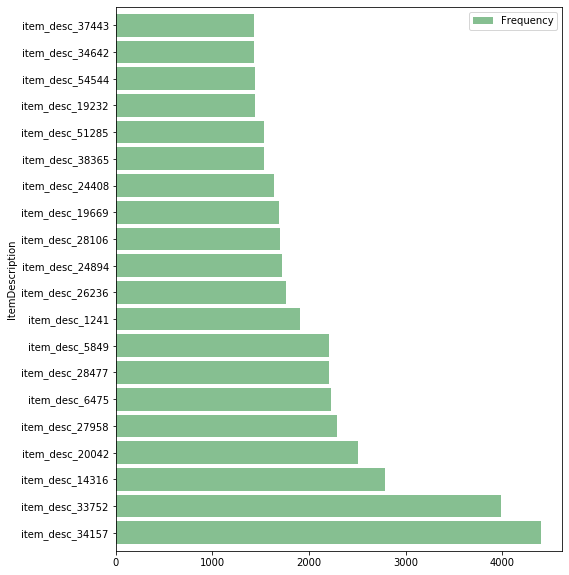

In [7]:
#frequencies of ItemDescription

fs_freq_item=sales.groupby(['ItemDescription']).size().reset_index(name='Frequency')
fs_freq_item=fs_freq_item.sort_values(by=['Frequency'], ascending =[False])
a=fs_freq_item.head(20)
ax = a.plot(kind='barh', x='ItemDescription', y='Frequency',figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

In [8]:
# relative frequencies

a=sales['ItemDescription'].value_counts(True).reset_index(name='FrequencyRelative')
a['FrequencyRelative']=a['FrequencyRelative']*100
b=a.sort_values(by=['FrequencyRelative'], ascending =[False])
ab=b.head(30)

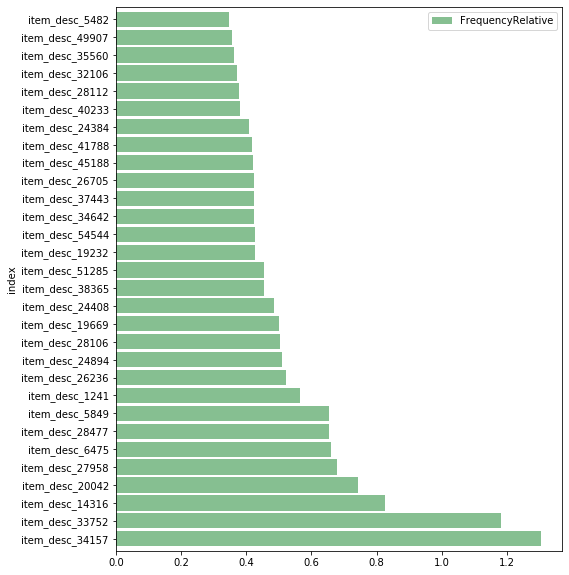

In [9]:
ax = ab.plot(kind='barh', x='index', y='FrequencyRelative',figsize=(8, 10), color='#86bf91', zorder=2,width=0.85)

In [10]:
a=sales.groupby(['ItemDescription']).agg(['count'])

In [11]:
a=sales.groupby(['ItemDescription']).size().reset_index(name='counts')
a
a[a.counts <5]

ItemDescription  counts
5     item_desc_10081       1
15    item_desc_10180       3
17    item_desc_10221       3
19    item_desc_10240       3
20    item_desc_10241       2
...               ...     ...
5109   item_desc_9923       1
5110   item_desc_9929       2
5112   item_desc_9930       2
5113   item_desc_9942       1
5117   item_desc_9979       2

[1043 rows x 2 columns]

In [12]:
#get table with counts per ItemDescription
fs_ON = (sales.groupby(['OrderNumber', 'ItemDescription'])['Quantity'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('OrderNumber')) 
fs_ON.head(5)

ItemDescription      item_desc_1001  item_desc_10013  item_desc_1004  \
OrderNumber                                                            
order_number_100092             0.0              0.0             0.0   
order_number_100111             0.0              0.0             0.0   
order_number_10012              0.0              0.0             0.0   
order_number_100150             0.0              0.0             0.0   
order_number_100269             0.0              0.0             0.0   

ItemDescription      item_desc_10053  item_desc_1006  item_desc_10081  \
OrderNumber                                                             
order_number_100092              0.0             0.0              0.0   
order_number_100111              0.0             0.0              0.0   
order_number_10012               0.0             0.0              0.0   
order_number_100150              0.0             0.0              0.0   
order_number_100269              0.0             0.0              0.0   

ItemDescription      item_desc_101  item_desc_10117  item_desc_10121  \
OrderNumber                                                            
order_number_100092            0.0              0.0              0.0   
order_number_100111            0.0              0.0              0.0   
order_number_10012             0.0              0.0              0.0   
order_number_100150            0.0              0.0              0.0   
order_number_100269            0.0              0.0              0.0   

ItemDescription      item_desc_10131  ...  item_desc_9929  item_desc_993  \
OrderNumber                           ...                                  
order_number_100092              0.0  ...             0.0            0.0   
order_number_100111              0.0  ...             0.0            0.0   
order_number_10012               0.0  ...             0.0            0.0   
order_number_100150              0.0  ...             0.0            0.0   
order_number_100269              0.0  ...             0.0            0.0   

ItemDescription      item_desc_9930  item_desc_9942  item_desc_9944  \
OrderNumber                                                           
order_number_100092             0.0             0.0             0.0   
order_number_100111             0.0             0.0             0.0   
order_number_10012              0.0             0.0             0.0   
order_number_100150             0.0             0.0             0.0   
order_number_100269             0.0             0.0             0.0   

ItemDescription      item_desc_9957  item_desc_9976  item_desc_9979  \
OrderNumber                                                           
order_number_100092             0.0             0.0             0.0   
order_number_100111             0.0             0.0             0.0   
order_number_10012              0.0             0.0             0.0   
order_number_100150             0.0             0.0             0.0   
order_number_100269             0.0             0.0             0.0   

ItemDescription      item_desc_9980  item_desc_9996  
OrderNumber                                          
order_number_100092             0.0             0.0  
order_number_100111             0.0             0.0  
order_number_10012              0.0             0.0  
order_number_100150             0.0             0.0  
order_number_100269             0.0             0.0  

[5 rows x 5120 columns]

In [13]:
def hot_encode(x): 
    if(x<= 0): 
        return 0
    if(x>= 1): 
        return 1

In [14]:
# Encoding the datasets 
fs_ON_encoded = fs_ON.applymap(hot_encode) 
fs_ON = fs_ON_encoded 

In [15]:
fs_ON.head(5)

ItemDescription      item_desc_1001  item_desc_10013  item_desc_1004  \
OrderNumber                                                            
order_number_100092               0                0               0   
order_number_100111               0                0               0   
order_number_10012                0                0               0   
order_number_100150               0                0               0   
order_number_100269               0                0               0   

ItemDescription      item_desc_10053  item_desc_1006  item_desc_10081  \
OrderNumber                                                             
order_number_100092                0               0                0   
order_number_100111                0               0                0   
order_number_10012                 0               0                0   
order_number_100150                0               0                0   
order_number_100269                0               0                0   

ItemDescription      item_desc_101  item_desc_10117  item_desc_10121  \
OrderNumber                                                            
order_number_100092              0                0                0   
order_number_100111              0                0                0   
order_number_10012               0                0                0   
order_number_100150              0                0                0   
order_number_100269              0                0                0   

ItemDescription      item_desc_10131  ...  item_desc_9929  item_desc_993  \
OrderNumber                           ...                                  
order_number_100092                0  ...               0              0   
order_number_100111                0  ...               0              0   
order_number_10012                 0  ...               0              0   
order_number_100150                0  ...               0              0   
order_number_100269                0  ...               0              0   

ItemDescription      item_desc_9930  item_desc_9942  item_desc_9944  \
OrderNumber                                                           
order_number_100092               0               0               0   
order_number_100111               0               0               0   
order_number_10012                0               0               0   
order_number_100150               0               0               0   
order_number_100269               0               0               0   

ItemDescription      item_desc_9957  item_desc_9976  item_desc_9979  \
OrderNumber                                                           
order_number_100092               0               0               0   
order_number_100111               0               0               0   
order_number_10012                0               0               0   
order_number_100150               0               0               0   
order_number_100269               0               0               0   

ItemDescription      item_desc_9980  item_desc_9996  
OrderNumber                                          
order_number_100092               0               0  
order_number_100111               0               0  
order_number_10012                0               0  
order_number_100150               0               0  
order_number_100269               0               0  

[5 rows x 5120 columns]

In [16]:
# create assocition with support > 0.001
frq_items = apriori(fs_ON, min_support = 0.01, use_colnames = True)
frq_items

support                                           itemsets
0   0.010785                                   (item_desc_1055)
1   0.020567                                  (item_desc_11463)
2   0.013544                                  (item_desc_12290)
3   0.013042                                   (item_desc_1241)
4   0.010283                                  (item_desc_12683)
..       ...                                                ...
63  0.013544                 (item_desc_19669, item_desc_27958)
64  0.012792                 (item_desc_34642, item_desc_24408)
65  0.011287                  (item_desc_28477, item_desc_5849)
66  0.012290                 (item_desc_33558, item_desc_40074)
67  0.011036  (item_desc_17612, item_desc_39168, item_desc_1...

[68 rows x 2 columns]

In [17]:
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules.head(10))
rules=rules.head(10)

                           antecedents        consequents  antecedent support  \
7                    (item_desc_28514)  (item_desc_14675)            0.011537   
23  (item_desc_17612, item_desc_11463)  (item_desc_39168)            0.011287   
22  (item_desc_17612, item_desc_39168)  (item_desc_11463)            0.011287   
20                   (item_desc_33558)  (item_desc_40074)            0.012792   
3                    (item_desc_39168)  (item_desc_11463)            0.014296   
12                   (item_desc_19539)   (item_desc_9209)            0.019062   
13                    (item_desc_9209)  (item_desc_19539)            0.019564   
16                   (item_desc_34642)  (item_desc_24408)            0.014296   
10                   (item_desc_17612)  (item_desc_39168)            0.013544   
0                    (item_desc_17612)  (item_desc_11463)            0.013544   

    consequent support   support  confidence       lift  leverage  conviction  
7             0.017557  0.01

In [18]:
support=rules.as_matrix(columns=['support'])
confidence=rules.as_matrix(columns=['confidence'])

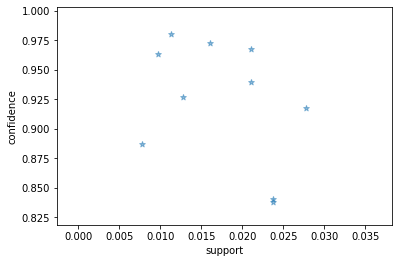

In [19]:
for i in range (len(support)):
    support[i] = support[i] + 0.0025 * (random.randint(1,10) - 5) 
    confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)
 
plt.scatter(support, confidence,   alpha=0.5, marker="*")
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

In [20]:
def draw_graph(rules, rules_to_show):
    import networkx as nx  
    G1 = nx.DiGraph()
    plt.figure(1,figsize=(15,10))
    color_map=[]
    N = 50
    colors = np.random.rand(N)    
    strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5']   
    
    for i in range (rules_to_show):      
        G1.add_nodes_from(["R"+str(i)])
    
        for a in rules.iloc[i]['antecedents']:

            G1.add_nodes_from([a])

            G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)

        for c in rules.iloc[i]['consequents']:

            G1.add_nodes_from([c])

            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)            
  
            
    for node in G1:
        found_a_string = False

        for item in strs: 
            if node==item:
                found_a_string = True

        if found_a_string:
            color_map.append('yellow')
        else:
            color_map.append('green') 

        
    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]
 
    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=20, with_labels=False)            
   
    for p in pos:  # raise text positions
        pos[p][1] += 0.07
    nx.draw_networkx_labels(G1, pos)
 
    plt.show()

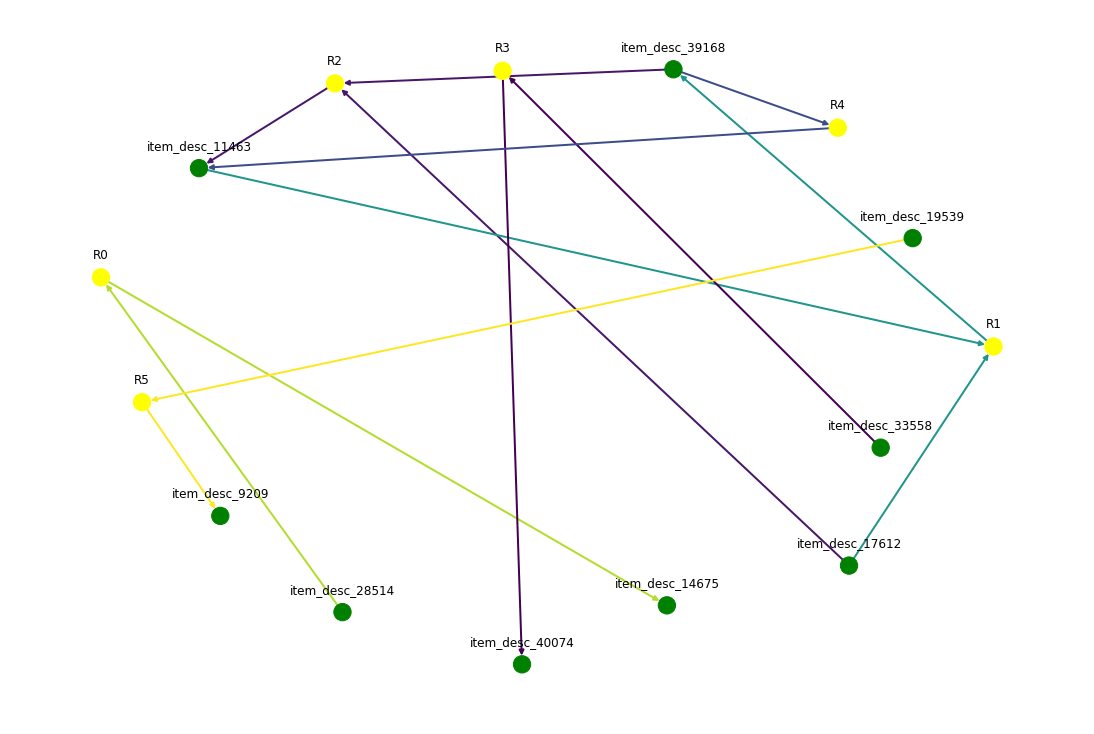

In [21]:
draw_graph(rules, 6)

In [23]:
rules.head(10)

antecedents        consequents  antecedent support  \
7                    (item_desc_28514)  (item_desc_14675)            0.011537   
23  (item_desc_17612, item_desc_11463)  (item_desc_39168)            0.011287   
22  (item_desc_17612, item_desc_39168)  (item_desc_11463)            0.011287   
20                   (item_desc_33558)  (item_desc_40074)            0.012792   
3                    (item_desc_39168)  (item_desc_11463)            0.014296   
12                   (item_desc_19539)   (item_desc_9209)            0.019062   
13                    (item_desc_9209)  (item_desc_19539)            0.019564   
16                   (item_desc_34642)  (item_desc_24408)            0.014296   
10                   (item_desc_17612)  (item_desc_39168)            0.013544   
0                    (item_desc_17612)  (item_desc_11463)            0.013544   

    consequent support   support  confidence       lift  leverage  conviction  
7             0.017557  0.011287    0.978261  55.718944  0.011084   45.192375  
23            0.014296  0.011036    0.977778  68.392982  0.010875   44.356659  
22            0.020567  0.011036    0.977778  47.541463  0.010804   44.074492  
20            0.019313  0.012290    0.960784  49.748663  0.012043   25.007524  
3             0.020567  0.013544    0.947368  46.062901  0.013250   18.609230  
12            0.019564  0.017808    0.934211  47.752530  0.017435   14.902634  
13            0.019062  0.017808    0.910256  47.752530  0.017435   10.930453  
16            0.016554  0.012792    0.894737  54.050239  0.012555    9.342739  
10            0.014296  0.011287    0.833333  58.289474  0.011093    5.914221  
0             0.020567  0.011287    0.833333  40.518293  0.011008    5.876599

In [24]:
#Associiton between customer and items
sales['ItemCategory'].unique

<bound method Series.unique of 29526     item_cat_13
32568     item_cat_13
32569     item_cat_15
32570     item_cat_15
32571     item_cat_15
             ...     
18402     item_cat_11
18403     item_cat_11
18380      item_cat_8
18386     item_cat_11
134707     item_cat_2
Name: ItemCategory, Length: 337153, dtype: object>

In [25]:
sales.head(5)

Date          OrderNumber  OrderLineNumber  Quantity  SellPrice  \
29526  01/02/2014  order_number_111590              130         3   29.33326   
32568  01/02/2014  order_number_111590              300         1  111.99972   
32569  01/02/2014  order_number_111590              310         3  918.66437   
32570  01/02/2014  order_number_111590              310         2   35.99991   
32571  01/02/2014  order_number_111590              310         1  729.33151   

             CCN         PartnerNumber  Material ItemCategoryGroup  \
29526  ccn_59201   partner_number_1153  mat_2998    item_cat_grp_6   
32568  ccn_17874  partner_number_40010  mat_5233    item_cat_grp_6   
32569  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1   
32570  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1   
32571  ccn_35441  partner_number_14416  mat_2491    item_cat_grp_1   

      ItemCategory  ... Region SubRegion                    Industry  \
29526  item_cat_13  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   
32568  item_cat_13  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   
32569  item_cat_15  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   
32570  item_cat_15  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   
32571  item_cat_15  ...    NaN      West  WATER SYSTEMS EXTR & TRMNT   

      IndustryGroup       Plant   PlantType     PlantPlatform  \
29526         WATER      Moosic  Unassigned  plant_platform_2   
32568         WATER  Chesapeake  Unassigned  plant_platform_1   
32569         WATER  Chesapeake  Unassigned  plant_platform_1   
32570         WATER  Chesapeake  Unassigned  plant_platform_1   
32571         WATER  Chesapeake  Unassigned  plant_platform_1   

                Market MonthYear Column 32  
29526  Water Resources   01/2014       NaN  
32568  Water Resources   01/2014       NaN  
32569  Water Resources   01/2014       NaN  
32570  Water Resources   01/2014       NaN  
32571  Water Resources   01/2014       NaN  

[5 rows x 32 columns]

In [26]:
list(sales.columns) 

['Date',
 'OrderNumber',
 'OrderLineNumber',
 'Quantity',
 'SellPrice',
 'CCN',
 'PartnerNumber',
 'Material',
 'ItemCategoryGroup',
 'ItemCategory',
 'ItemDescription',
 'ProductCode',
 'ProductDescription',
 'NounCodeDescription',
 'NounCode',
 'ShipFrom',
 'CustomerName',
 'CustId',
 'City',
 'State',
 'PostalCode',
 'Country',
 'Region',
 'SubRegion',
 'Industry',
 'IndustryGroup',
 'Plant',
 'PlantType',
 'PlantPlatform',
 'Market',
 'MonthYear',
 'Column 32']

In [27]:
#get table with counts per ItemDescription
fs_ON_cust = (sales.groupby([ 'ItemDescription','CustId'])['Quantity'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('ItemDescription')) 
fs_ON_cust.head(5)

CustId           cust_id_1037  cust_id_1044  cust_id_1072  cust_id_1110  \
ItemDescription                                                           
item_desc_1001            0.0           0.0           0.0           0.0   
item_desc_10013           0.0           0.0           0.0           0.0   
item_desc_1004            0.0           0.0           0.0           0.0   
item_desc_10053           0.0           0.0           0.0           0.0   
item_desc_1006            0.0           0.0           0.0           0.0   

CustId           cust_id_1140  cust_id_1198  cust_id_121  cust_id_1211  \
ItemDescription                                                          
item_desc_1001            0.0           0.0          0.0           0.0   
item_desc_10013           0.0           0.0          0.0           0.0   
item_desc_1004            0.0           0.0          0.0           0.0   
item_desc_10053           0.0           0.0          0.0           0.0   
item_desc_1006            0.0           0.0          0.0           0.0   

CustId           cust_id_124  cust_id_1260  ...  cust_id_703  cust_id_761  \
ItemDescription                             ...                             
item_desc_1001           0.0           0.0  ...          0.0          0.0   
item_desc_10013          0.0           0.0  ...          0.0          0.0   
item_desc_1004           0.0           0.0  ...          0.0          0.0   
item_desc_10053          0.0           0.0  ...          0.0          0.0   
item_desc_1006           0.0           0.0  ...          0.0          0.0   

CustId           cust_id_804  cust_id_829  cust_id_849  cust_id_925  \
ItemDescription                                                       
item_desc_1001           0.0          0.0          0.0          0.0   
item_desc_10013          0.0          0.0          0.0          0.0   
item_desc_1004           0.0          0.0          0.0          0.0   
item_desc_10053          0.0          0.0          0.0          0.0   
item_desc_1006           0.0          0.0          0.0          0.0   

CustId           cust_id_928  cust_id_946  cust_id_963  cust_id_996  
ItemDescription                                                      
item_desc_1001           0.0          0.0          0.0          0.0  
item_desc_10013          0.0          0.0          0.0          0.0  
item_desc_1004           0.0          0.0          0.0          0.0  
item_desc_10053          0.0          0.0          0.0          0.0  
item_desc_1006           0.0          0.0          0.0          0.0  

[5 rows x 134 columns]

In [28]:
# Encoding the datasets 
fs_ON_cust_encoded = fs_ON_cust.applymap(hot_encode) 
fs_ON_cust = fs_ON_cust_encoded 
fs_ON_cust.head(5)

CustId           cust_id_1037  cust_id_1044  cust_id_1072  cust_id_1110  \
ItemDescription                                                           
item_desc_1001              0             0             0             0   
item_desc_10013             0             0             0             0   
item_desc_1004              0             0             0             0   
item_desc_10053             0             0             0             0   
item_desc_1006              0             0             0             0   

CustId           cust_id_1140  cust_id_1198  cust_id_121  cust_id_1211  \
ItemDescription                                                          
item_desc_1001              0             0            0             0   
item_desc_10013             0             0            0             0   
item_desc_1004              0             0            0             0   
item_desc_10053             0             0            0             0   
item_desc_1006              0             0            0             0   

CustId           cust_id_124  cust_id_1260  ...  cust_id_703  cust_id_761  \
ItemDescription                             ...                             
item_desc_1001             0             0  ...            0            0   
item_desc_10013            0             0  ...            0            0   
item_desc_1004             0             0  ...            0            0   
item_desc_10053            0             0  ...            0            0   
item_desc_1006             0             0  ...            0            0   

CustId           cust_id_804  cust_id_829  cust_id_849  cust_id_925  \
ItemDescription                                                       
item_desc_1001             0            0            0            0   
item_desc_10013            0            0            0            0   
item_desc_1004             0            0            0            0   
item_desc_10053            0            0            0            0   
item_desc_1006             0            0            0            0   

CustId           cust_id_928  cust_id_946  cust_id_963  cust_id_996  
ItemDescription                                                      
item_desc_1001             0            0            0            0  
item_desc_10013            0            0            0            0  
item_desc_1004             0            0            0            0  
item_desc_10053            0            0            0            0  
item_desc_1006             0            0            0            0  

[5 rows x 134 columns]

In [29]:
# create assocition with support > 0.001
frq_items_cust = apriori(fs_ON_cust, min_support = 0.01, use_colnames = True)
frq_items_cust

support                                   itemsets
0    0.088672                             (cust_id_1549)
1    0.044727                             (cust_id_1556)
2    0.153906                             (cust_id_1626)
3    0.029883                             (cust_id_1653)
4    0.047266                              (cust_id_190)
..        ...                                        ...
101  0.011719  (cust_id_1626, cust_id_3970, cust_id_576)
102  0.012891  (cust_id_1626, cust_id_3970, cust_id_674)
103  0.013086  (cust_id_1626, cust_id_4196, cust_id_576)
104  0.011328  (cust_id_3970, cust_id_4196, cust_id_576)
105  0.010352  (cust_id_3970, cust_id_674, cust_id_4196)

[106 rows x 2 columns]

In [30]:
rules_cust = association_rules(frq_items_cust, metric ="lift", min_threshold = 1) 
rules_cust = rules_cust.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules_cust.head(10))
rules_cust=rules_cust.head(10)

                      antecedents     consequents  antecedent support  \
116  (cust_id_1626, cust_id_4020)  (cust_id_1549)            0.016406   
140  (cust_id_4020, cust_id_3970)  (cust_id_1549)            0.016602   
75                 (cust_id_2774)   (cust_id_576)            0.024609   
106  (cust_id_3936, cust_id_1549)  (cust_id_1626)            0.018750   
136  (cust_id_3936, cust_id_1549)  (cust_id_3970)            0.018750   
154   (cust_id_674, cust_id_1549)  (cust_id_3970)            0.018555   
148  (cust_id_4196, cust_id_1549)  (cust_id_3970)            0.017969   
118  (cust_id_4020, cust_id_1549)  (cust_id_1626)            0.019727   
124  (cust_id_4196, cust_id_1549)  (cust_id_1626)            0.017969   
166  (cust_id_3970, cust_id_3936)  (cust_id_1626)            0.021484   

     consequent support   support  confidence      lift  leverage  conviction  
116            0.088672  0.012109    0.738095  8.323893  0.010655    3.479616  
140            0.088672  0.011719   

In [31]:
support=rules_cust.as_matrix(columns=['support'])
confidence=rules_cust.as_matrix(columns=['confidence'])

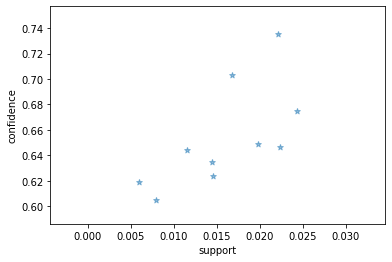

In [32]:
for i in range (len(support)):
    support[i] = support[i] + 0.0025 * (random.randint(1,10) - 5)   
    confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)
 
plt.scatter(support, confidence,   alpha=0.5, marker="*")
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

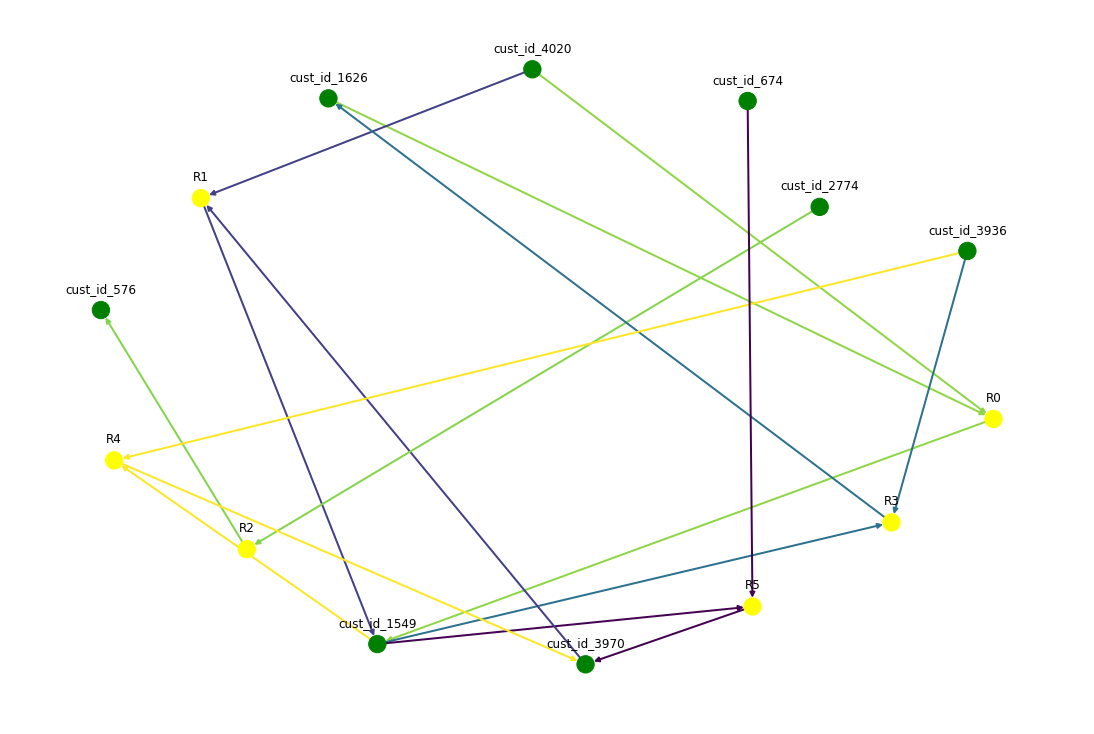

In [33]:
draw_graph(rules_cust, 6)

In [34]:
#Associiton between customer and category
sales['ItemCategory'].unique

<bound method Series.unique of 29526     item_cat_13
32568     item_cat_13
32569     item_cat_15
32570     item_cat_15
32571     item_cat_15
             ...     
18402     item_cat_11
18403     item_cat_11
18380      item_cat_8
18386     item_cat_11
134707     item_cat_2
Name: ItemCategory, Length: 337153, dtype: object>

In [35]:
#get table with counts per ItemDescription
fs_ON_cat = (sales.groupby([ 'ItemCategory','CustId'])['Quantity'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('ItemCategory')) 
fs_ON_cat.head(5)

CustId        cust_id_1037  cust_id_1044  cust_id_1072  cust_id_1110  \
ItemCategory                                                           
item_cat_0             0.0           0.0           0.0           0.0   
item_cat_1             0.0           0.0           0.0           0.0   
item_cat_10            0.0           0.0           0.0           0.0   
item_cat_11            0.0          24.0           0.0           8.0   
item_cat_12            0.0           0.0           1.0           0.0   

CustId        cust_id_1140  cust_id_1198  cust_id_121  cust_id_1211  \
ItemCategory                                                          
item_cat_0             0.0           0.0          0.0           0.0   
item_cat_1            12.0           0.0        113.0           0.0   
item_cat_10            0.0           0.0          0.0           0.0   
item_cat_11           36.0           0.0        239.0         105.0   
item_cat_12            0.0           0.0          0.0           0.0   

CustId        cust_id_124  cust_id_1260  ...  cust_id_703  cust_id_761  \
ItemCategory                             ...                             
item_cat_0            0.0           0.0  ...          0.0          0.0   
item_cat_1            0.0           0.0  ...          0.0         62.0   
item_cat_10           0.0           0.0  ...          0.0          0.0   
item_cat_11           0.0           6.0  ...          0.0         99.0   
item_cat_12           0.0           0.0  ...          0.0          0.0   

CustId        cust_id_804  cust_id_829  cust_id_849  cust_id_925  cust_id_928  \
ItemCategory                                                                    
item_cat_0            0.0          0.0          0.0          0.0          0.0   
item_cat_1           40.0          0.0          0.0         87.0          4.0   
item_cat_10           0.0          0.0          0.0          0.0          0.0   
item_cat_11         171.0          0.0          0.0        811.0          0.0   
item_cat_12           0.0          0.0          0.0          0.0          0.0   

CustId        cust_id_946  cust_id_963  cust_id_996  
ItemCategory                                         
item_cat_0            0.0          0.0          0.0  
item_cat_1            0.0          0.0          0.0  
item_cat_10           0.0          0.0          0.0  
item_cat_11          74.0         16.0          0.0  
item_cat_12           2.0          0.0          0.0  

[5 rows x 134 columns]

In [36]:
# Encoding the datasets 
fs_ON_cat_encoded = fs_ON_cat.applymap(hot_encode) 
fs_ON_cat = fs_ON_cat_encoded 
fs_ON_cat.head(5)

CustId        cust_id_1037  cust_id_1044  cust_id_1072  cust_id_1110  \
ItemCategory                                                           
item_cat_0               0             0             0             0   
item_cat_1               0             0             0             0   
item_cat_10              0             0             0             0   
item_cat_11              0             1             0             1   
item_cat_12              0             0             1             0   

CustId        cust_id_1140  cust_id_1198  cust_id_121  cust_id_1211  \
ItemCategory                                                          
item_cat_0               0             0            0             0   
item_cat_1               1             0            1             0   
item_cat_10              0             0            0             0   
item_cat_11              1             0            1             1   
item_cat_12              0             0            0             0   

CustId        cust_id_124  cust_id_1260  ...  cust_id_703  cust_id_761  \
ItemCategory                             ...                             
item_cat_0              0             0  ...            0            0   
item_cat_1              0             0  ...            0            1   
item_cat_10             0             0  ...            0            0   
item_cat_11             0             1  ...            0            1   
item_cat_12             0             0  ...            0            0   

CustId        cust_id_804  cust_id_829  cust_id_849  cust_id_925  cust_id_928  \
ItemCategory                                                                    
item_cat_0              0            0            0            0            0   
item_cat_1              1            0            0            1            1   
item_cat_10             0            0            0            0            0   
item_cat_11             1            0            0            1            0   
item_cat_12             0            0            0            0            0   

CustId        cust_id_946  cust_id_963  cust_id_996  
ItemCategory                                         
item_cat_0              0            0            0  
item_cat_1              0            0            0  
item_cat_10             0            0            0  
item_cat_11             1            1            0  
item_cat_12             1            0            0  

[5 rows x 134 columns]

In [51]:
# create assocition with support > 0.001
frq_items_cat = apriori(fs_ON_cat, min_support = 0.85, use_colnames = True)
frq_items_cat

support                                           itemsets
0     0.8750                                     (cust_id_1549)
1     0.9375                                     (cust_id_1626)
2     0.8750                                     (cust_id_2700)
3     0.8750                                     (cust_id_3902)
4     0.8750                                     (cust_id_3936)
..       ...                                                ...
128   0.8750  (cust_id_1626, cust_id_3902, cust_id_1549, cus...
129   0.8750  (cust_id_1626, cust_id_1549, cust_id_576, cust...
130   0.8750  (cust_id_3902, cust_id_1549, cust_id_576, cust...
131   0.8750  (cust_id_1626, cust_id_3902, cust_id_576, cust...
132   0.8750  (cust_id_1626, cust_id_3902, cust_id_1549, cus...

[133 rows x 2 columns]

In [62]:
rules_cat = association_rules(frq_items_cat, metric ="lift", min_threshold = 1) 
rules_cat = rules_cat.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules_cat.head(30))
rules_cat=rules_cat.head(10)

                     antecedents                   consequents  \
2                 (cust_id_3902)                (cust_id_1549)   
3                 (cust_id_1549)                (cust_id_3902)   
4                 (cust_id_3936)                (cust_id_1549)   
5                 (cust_id_1549)                (cust_id_3936)   
6                 (cust_id_3970)                (cust_id_1549)   
7                 (cust_id_1549)                (cust_id_3970)   
8                 (cust_id_4196)                (cust_id_1549)   
9                 (cust_id_1549)                (cust_id_4196)   
26                (cust_id_3902)                (cust_id_3936)   
27                (cust_id_3936)                (cust_id_3902)   
28                (cust_id_3970)                (cust_id_3902)   
29                (cust_id_3902)                (cust_id_3970)   
30                (cust_id_4196)                (cust_id_3902)   
31                (cust_id_3902)                (cust_id_4196)   
34        

In [63]:
support=rules_cust.as_matrix(columns=['support'])
confidence=rules_cust.as_matrix(columns=['confidence'])    


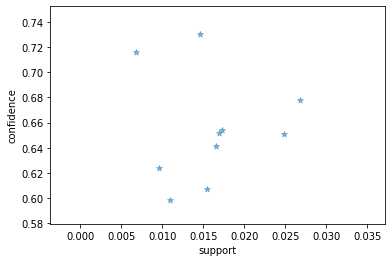

In [54]:
for i in range (len(support)):
    support[i] = support[i] + 0.0025 * (random.randint(1,10) - 5)   
    confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)
 
plt.scatter(support, confidence,   alpha=0.5, marker="*")
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

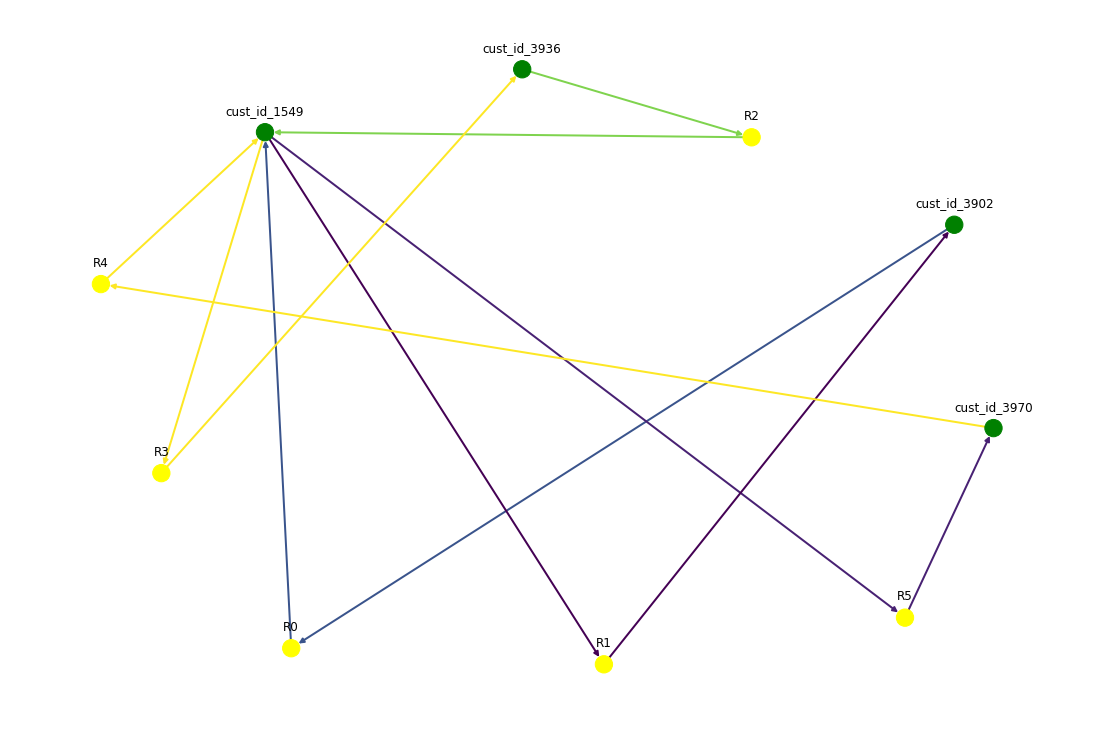

In [55]:
draw_graph(rules_cat, 6)